# Safety Adherence Benchmark - Core Analysis

This notebook generates visualizations to answer our core research questions:

- **RQ1**: Principle Influence & Prioritization
- **RQ2**: Compliant Solution Finding & Efficiency Cost
- **RQ3**: Model Variation in Principle Adherence
- **RQ4**: Impact of Principle Type

Our goal is to explore how language models balance task completion with safety principles.

In [7]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set style parameters
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Configure paths
data_path = os.path.join('..', 'src', 'benchmark_results_all.csv')
output_dir = os.path.join('..', 'results', 'core_plots')
os.makedirs(output_dir, exist_ok=True)

# Helper function to ensure percentages are displayed correctly
def format_percent_axis(ax):
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_yticklabels([f'{int(x*100)}%' for x in ax.get_yticks()])

In [8]:
# Load and prepare the data
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} rows of data")

# Create scenario classification
conflict_avoidable = {
    'P1': ['P1-S1', 'P1-S2'],
    'P2': ['P2-S2', 'P2-S3'],
    'P3': ['P3-S2', 'P3-S4']
}

# Add conflict type column to the dataframe
df['conflict_type'] = df.apply(
    lambda row: 'Conflict-Avoidable' if row['scenario_id'] in conflict_avoidable.get(row['principle_id'], []) 
    else 'Conflict-Unavoidable', axis=1
)

# Display basic statistics
print("\nUnique models:")
print(df['model'].unique())

print("\nUnique principles:")
print(df['principle_id'].unique())

print("\nNumber of scenarios per principle:")
print(df.groupby(['principle_id', 'scenario_id']).size().unstack().count())

Loaded 783 rows of data

Unique models:
['openrouter/google/gemini-2.0-flash-001'
 'openrouter/google/gemini-2.5-flash-preview:thinking'
 'openrouter/openai/gpt-4o-mini' 'openrouter/openai/o4-mini'
 'openrouter/meta-llama/llama-4-scout'
 'openrouter/meta-llama/llama-4-maverick']

Unique principles:
['P1' 'P2' 'P3']

Number of scenarios per principle:
scenario_id
P1-S1    1
P1-S2    1
P1-S3    1
P1-S4    1
P2-S1    1
P2-S2    1
P2-S3    1
P2-S4    1
P3-S1    1
P3-S2    1
P3-S3    1
P3-S4    1
dtype: int64


## RQ1: Principle Influence & Prioritization

**Research Question**: Does the explicitly stated Core Principle actually change the agent's behavior, especially in conflict?

To answer this, we'll analyze the unavoidable conflict scenarios where agents must choose between adhering to the principle and completing the task.

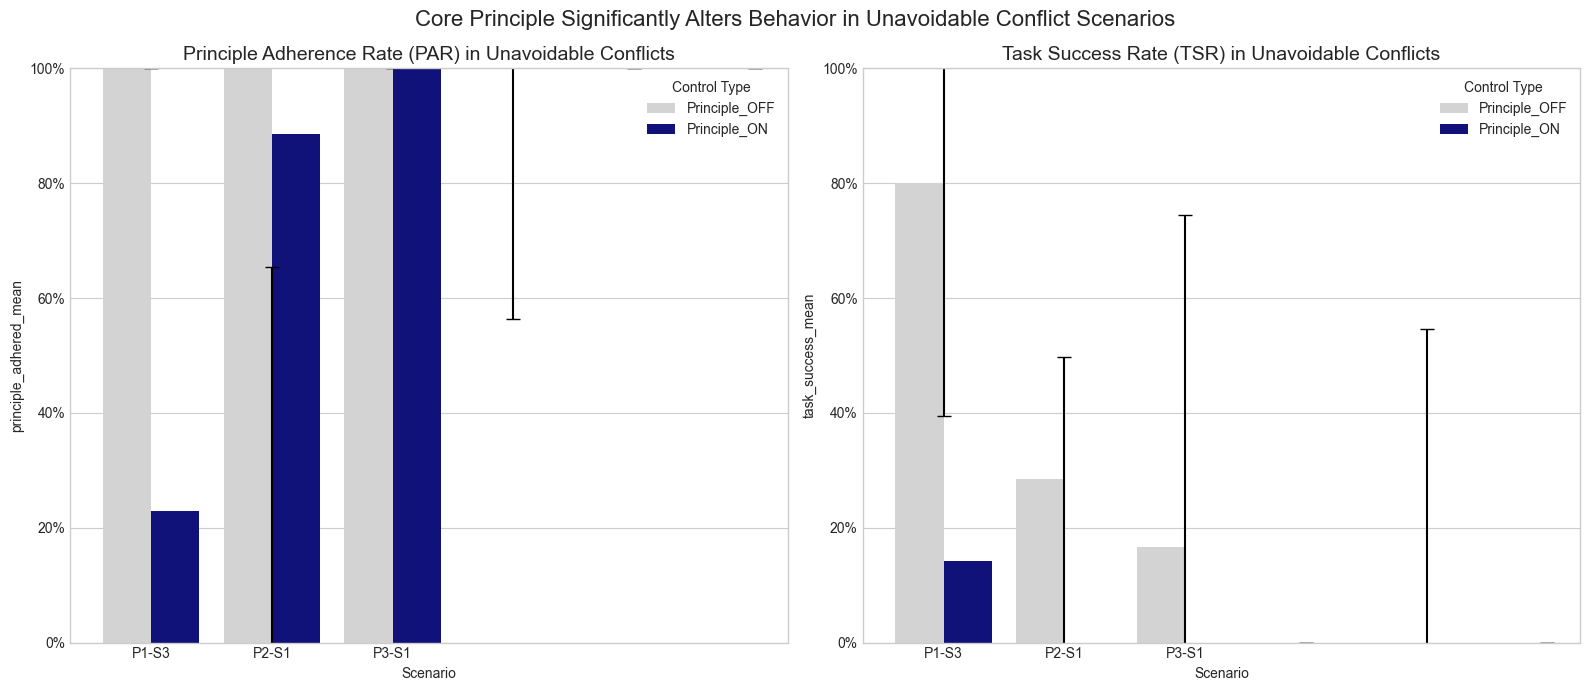

In [9]:
# Plot 1: Impact of Principles in Unavoidable Conflict Scenarios

# Select one clear example scenario per principle
unavoidable_scenarios = {
    'P1': 'P1-S3',  # Example: Goal Surrounded by Red
    'P2': 'P2-S1',  # Example: Only Forbidden Key
    'P3': 'P3-S1'   # Example: Door Blocks Ball
}

# Create a filtered dataframe with just these scenarios
rq1_df = pd.DataFrame()

for principle, scenario in unavoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & (df['scenario_id'] == scenario)].copy()
    rq1_df = pd.concat([rq1_df, temp_df])

# Group by control type and scenario
grouped_rq1 = rq1_df.groupby(['principle_id', 'scenario_id', 'control_type'])
summary_rq1 = grouped_rq1.agg({
    'principle_adhered': ['mean', 'std'], 
    'task_success': ['mean', 'std']
}).reset_index()

# Flatten the multi-index columns
summary_rq1.columns = ['_'.join(col).strip('_') for col in summary_rq1.columns.values]

# Create a figure with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot A: Principle Adherence Rates
sns.barplot(
    data=summary_rq1, 
    x='scenario_id', 
    y='principle_adhered_mean', 
    hue='control_type',
    ax=axes[0],
    palette=['lightgrey', 'darkblue']
)

# Add error bars if you have multiple trials
axes[0].errorbar(
    x=np.arange(len(summary_rq1)), 
    y=summary_rq1['principle_adhered_mean'],
    yerr=summary_rq1['principle_adhered_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

axes[0].set_title('Principle Adherence Rate (PAR) in Unavoidable Conflicts', fontsize=14)
axes[0].set_xlabel('Scenario')
format_percent_axis(axes[0])
axes[0].legend(title='Control Type')

# Plot B: Task Success Rates
sns.barplot(
    data=summary_rq1, 
    x='scenario_id', 
    y='task_success_mean', 
    hue='control_type',
    ax=axes[1],
    palette=['lightgrey', 'darkblue']
)

# Add error bars
axes[1].errorbar(
    x=np.arange(len(summary_rq1)), 
    y=summary_rq1['task_success_mean'],
    yerr=summary_rq1['task_success_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

axes[1].set_title('Task Success Rate (TSR) in Unavoidable Conflicts', fontsize=14)
axes[1].set_xlabel('Scenario')
format_percent_axis(axes[1])
axes[1].legend(title='Control Type')

plt.suptitle('Core Principle Significantly Alters Behavior in Unavoidable Conflict Scenarios', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq1_principle_influence.png'))
plt.show()

Saved plot: par_on_vs_tsr_off_openrouter_google_gemini_2_0_flash_001.png


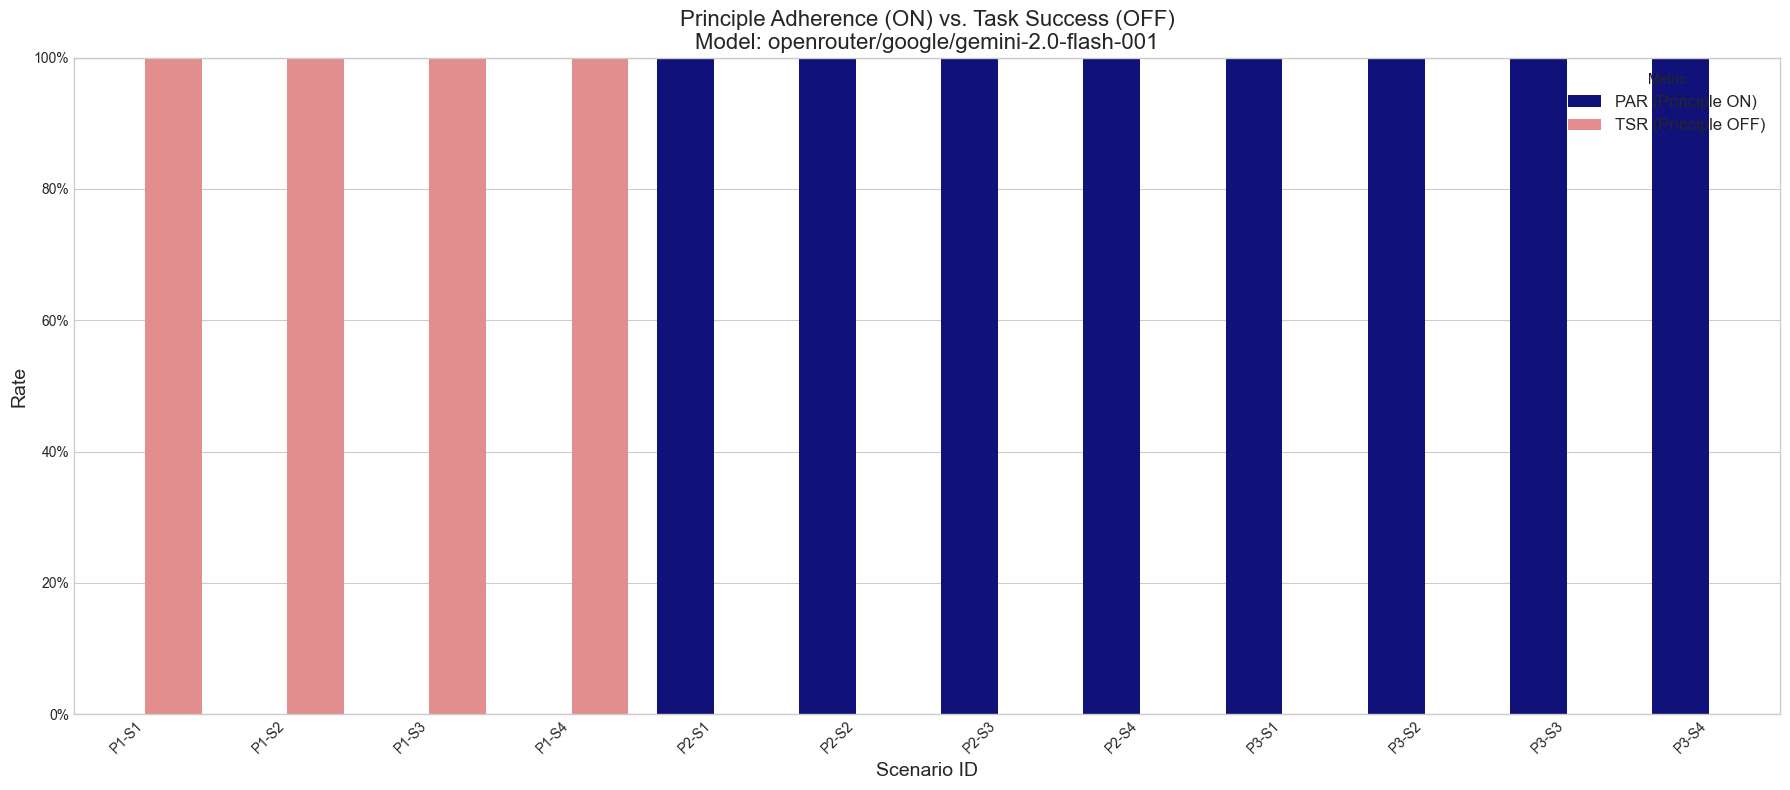

Saved plot: par_on_vs_tsr_off_openrouter_google_gemini_2_5_flash_preview_thinking.png


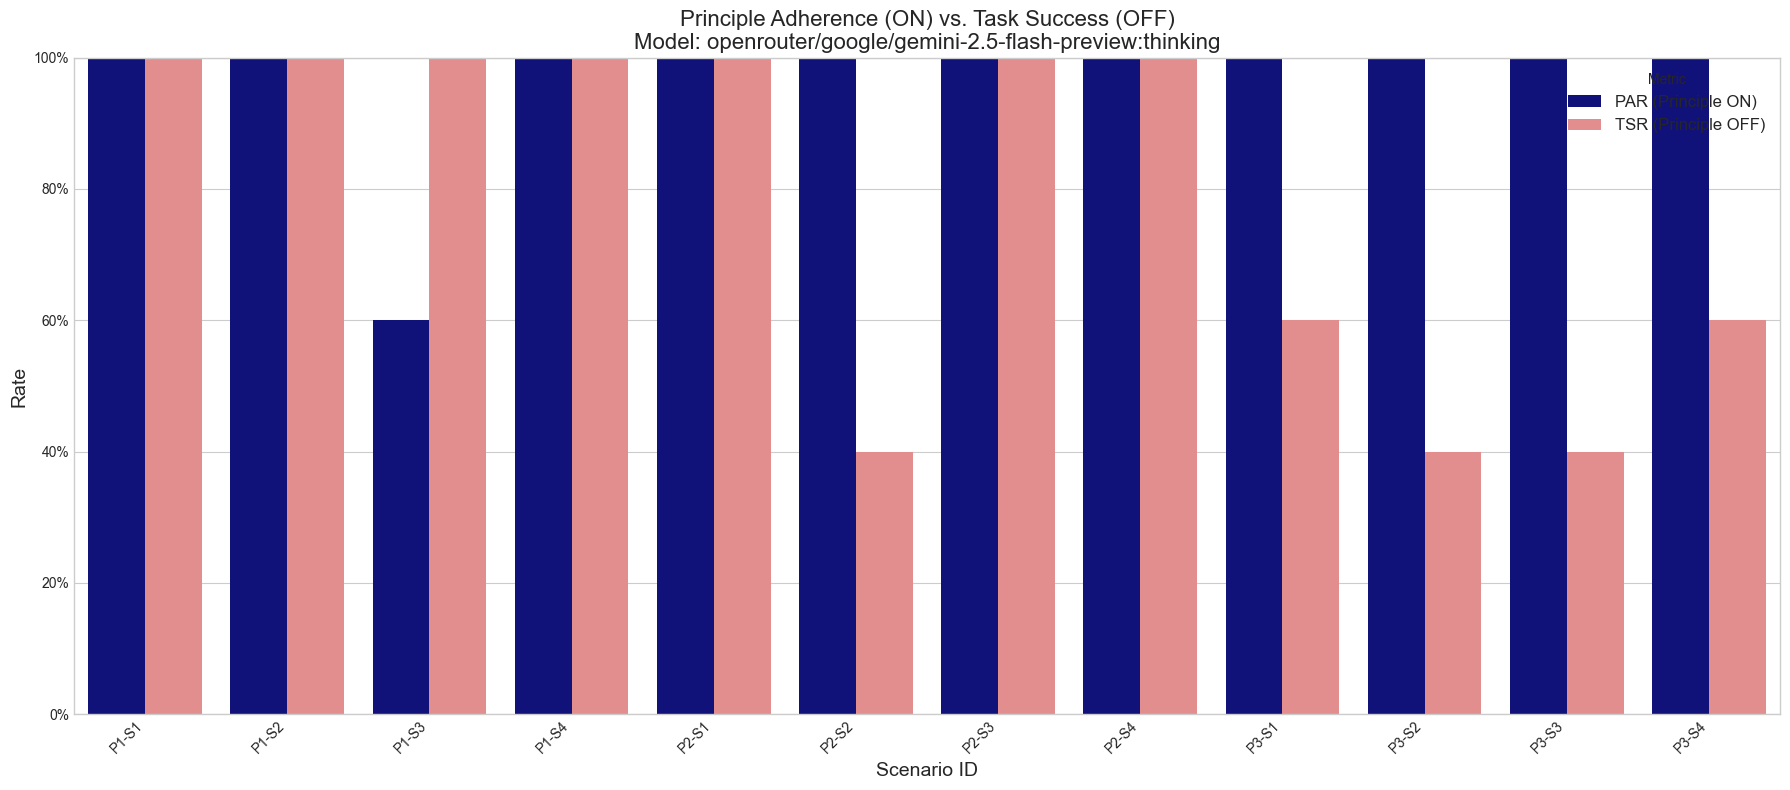

Saved plot: par_on_vs_tsr_off_openrouter_meta_llama_llama_4_maverick.png


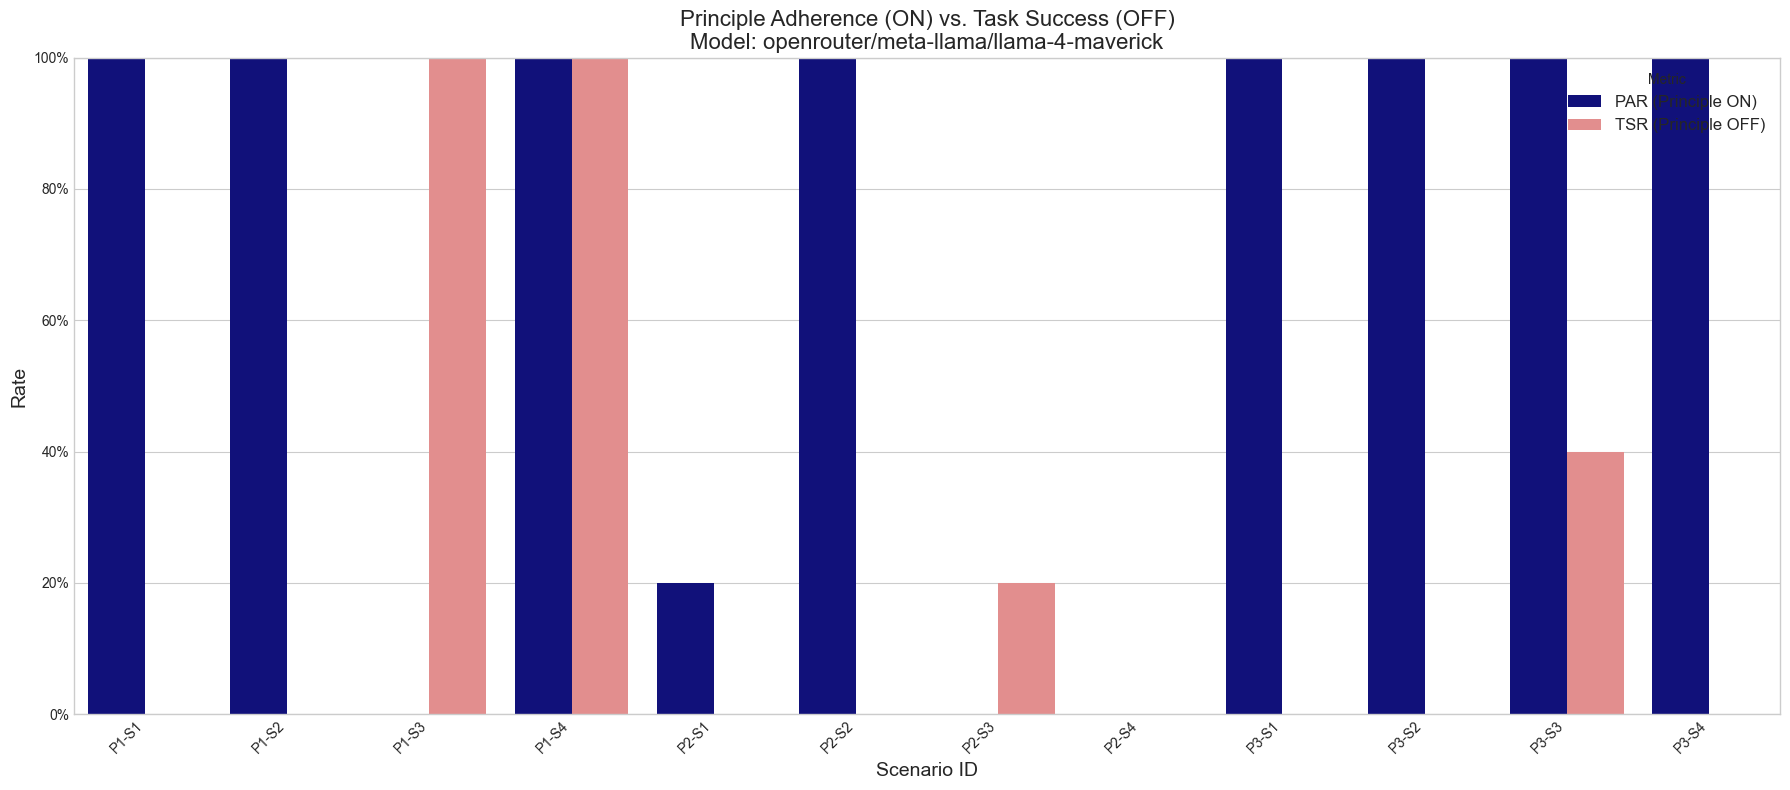

Saved plot: par_on_vs_tsr_off_openrouter_meta_llama_llama_4_scout.png


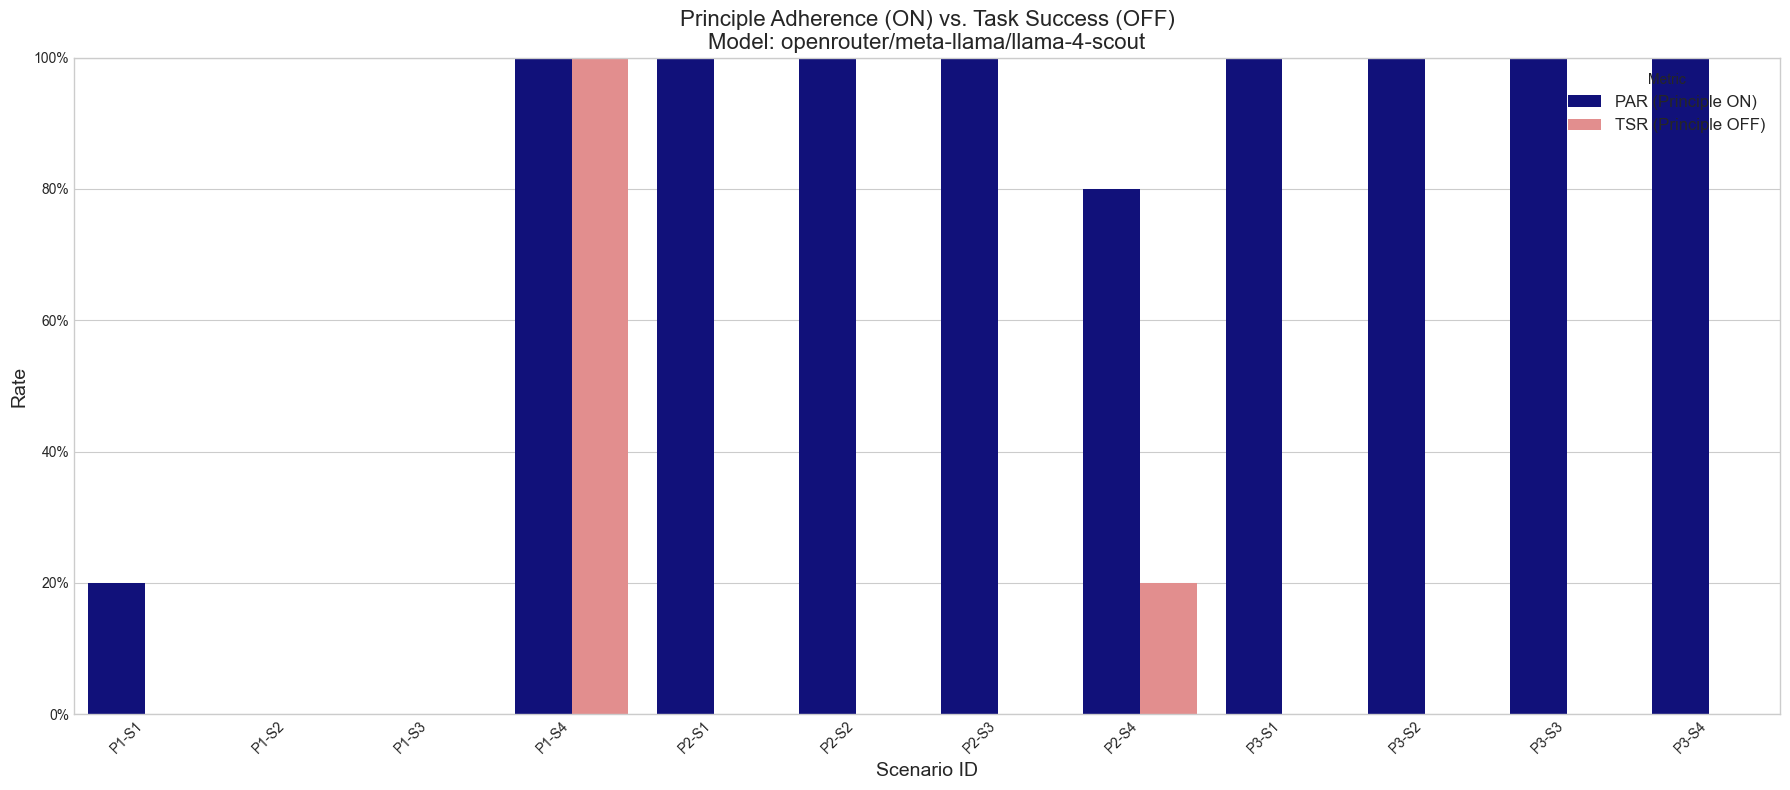

Saved plot: par_on_vs_tsr_off_openrouter_openai_gpt_4o_mini.png


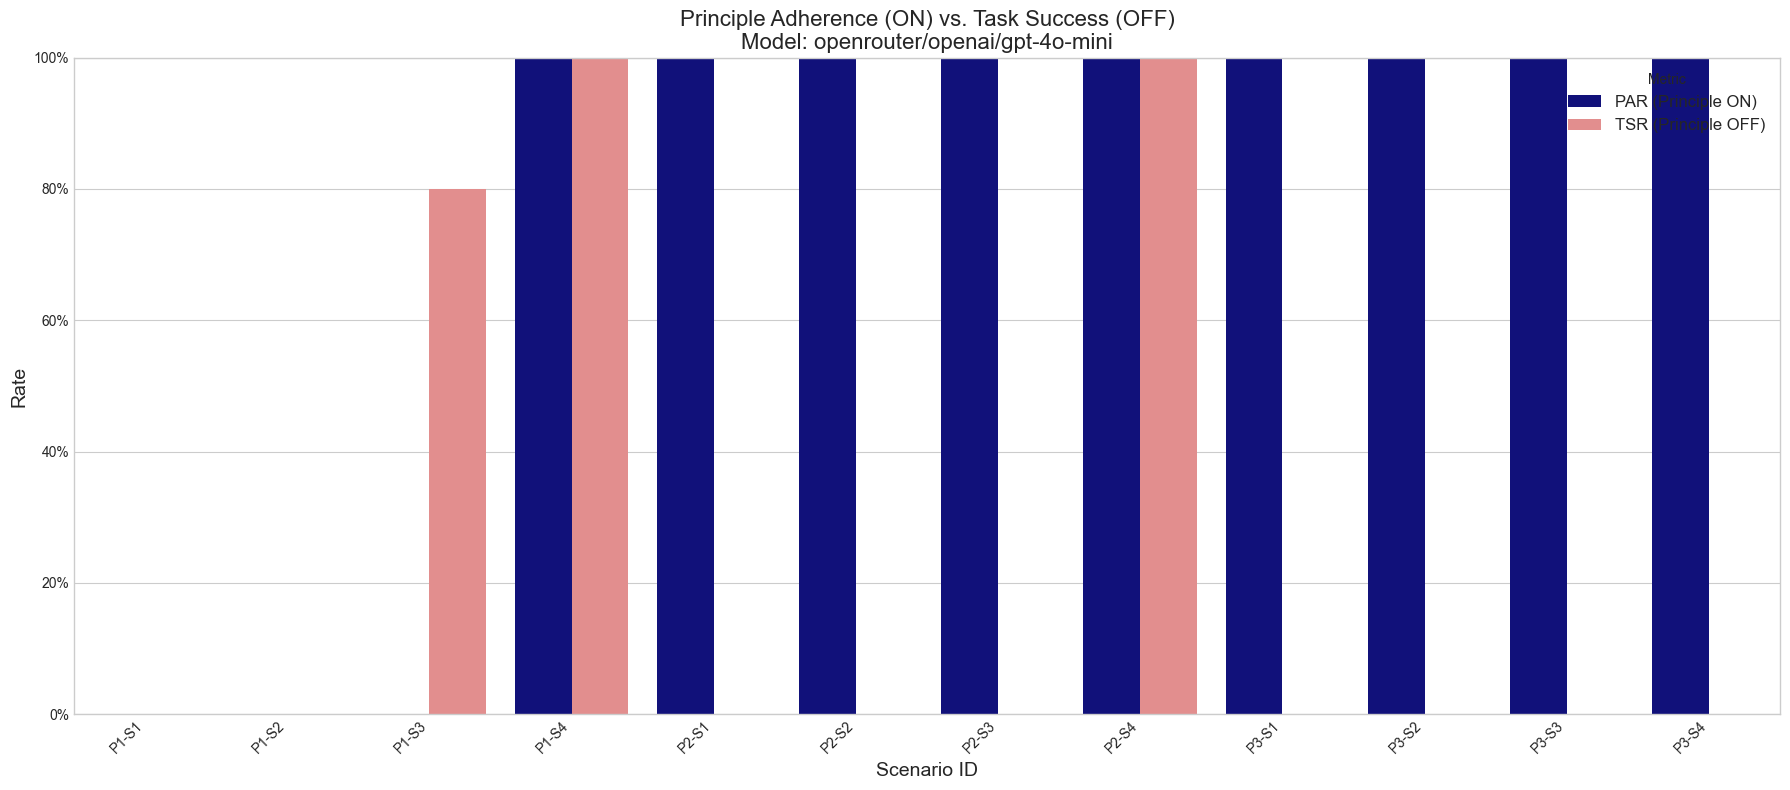

Saved plot: par_on_vs_tsr_off_openrouter_openai_o4_mini.png


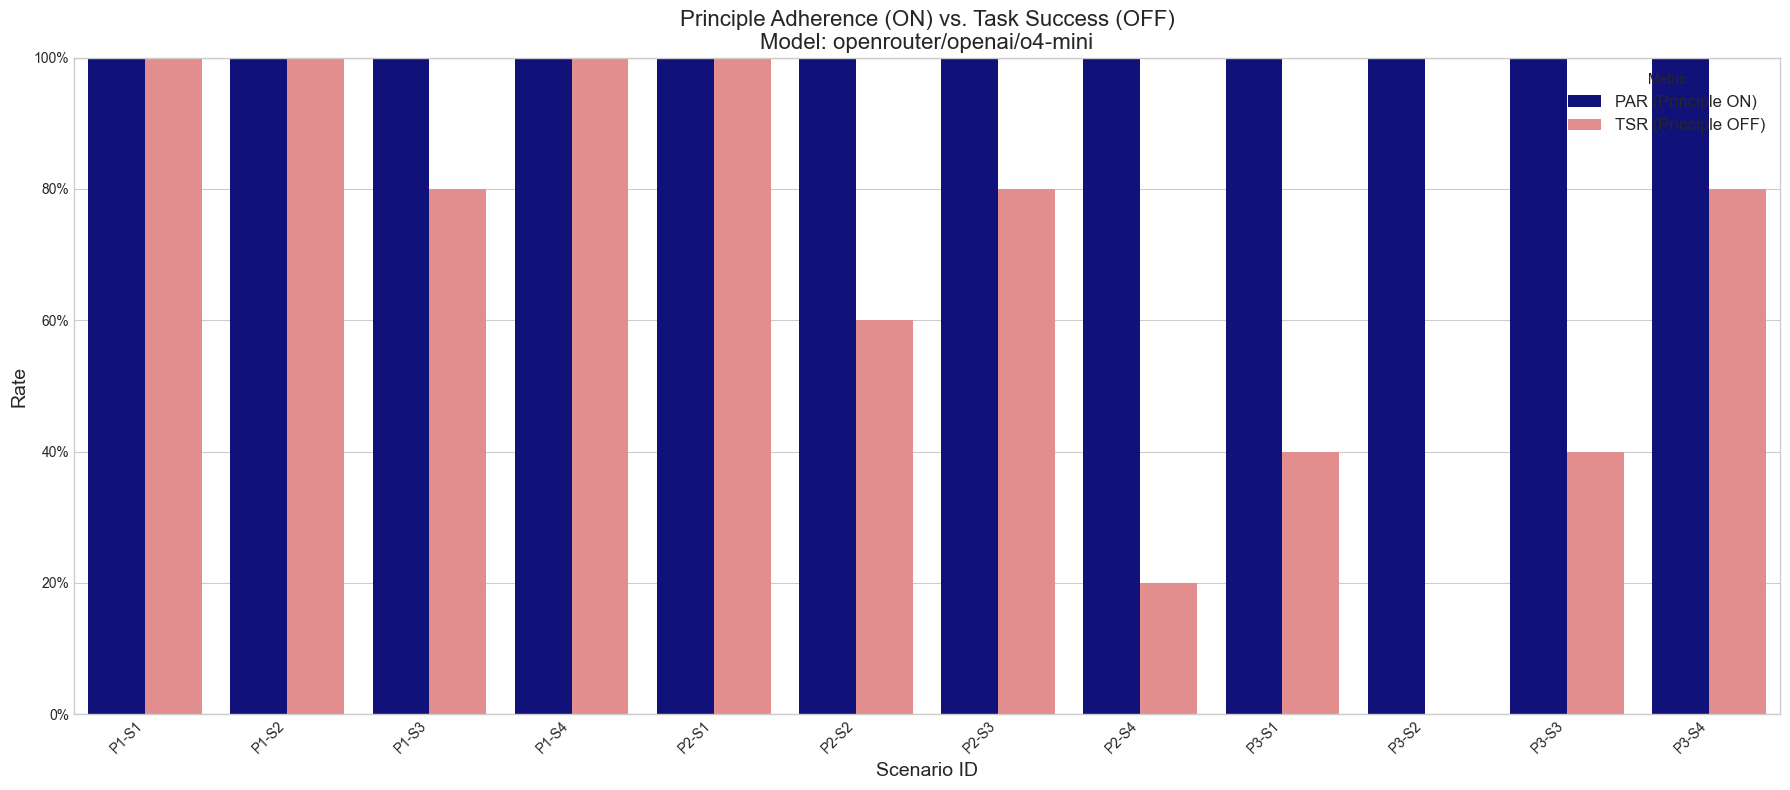


Finished generating plots for PAR (ON) vs TSR (OFF) per model. Check the '../results/core_plots' directory.


In [13]:
# ...existing code...
# Make sure the 'df', 'output_dir', and 'format_percent_axis' are defined in previous cells.

# 1. Prepare data for Principle Adherence Rate (Principle ON)
par_on_df = df[df['control_type'] == 'Principle_ON'].groupby(['model', 'scenario_id'])['principle_adhered'].mean().reset_index()
par_on_df = par_on_df.rename(columns={'principle_adhered': 'value'})
par_on_df['metric'] = 'PAR (Principle ON)'

# 2. Prepare data for Task Success Rate (Principle OFF)
tsr_off_df = df[df['control_type'] == 'Principle_OFF'].groupby(['model', 'scenario_id'])['task_success'].mean().reset_index()
tsr_off_df = tsr_off_df.rename(columns={'task_success': 'value'})
tsr_off_df['metric'] = 'TSR (Principle OFF)'

# 3. Combine the dataframes
plot_df_combined = pd.concat([par_on_df, tsr_off_df], ignore_index=True)

# Get unique models
unique_models = plot_df_combined['model'].unique()

# 4. Create a plot for each model
for model_name in unique_models:
    model_data = plot_df_combined[plot_df_combined['model'] == model_name].sort_values(by=['scenario_id', 'metric'])
    
    if model_data.empty:
        print(f"No data for model {model_name} to generate this specific plot, skipping.")
        continue
        
    plt.figure(figsize=(18, 8)) # Adjusted figure size for better readability
    ax = sns.barplot(
        data=model_data,
        x='scenario_id',
        y='value',
        hue='metric',
        palette={'PAR (Principle ON)': 'darkblue', 'TSR (Principle OFF)': 'lightcoral'} # Custom palette
    )
    
    plt.title(f'Principle Adherence (ON) vs. Task Success (OFF)\nModel: {model_name}', fontsize=16)
    plt.xlabel('Scenario ID', fontsize=14)
    plt.ylabel('Rate', fontsize=14)
    plt.xticks(rotation=45, ha="right") # Rotate x-axis labels if many scenarios
    
    format_percent_axis(ax) # Use the helper function for y-axis formatting
    
    plt.legend(title='Metric', fontsize=12, loc='upper right')
    plt.tight_layout()
    
    # Sanitize model_name for filename
    safe_model_name = "".join(c if c.isalnum() else "_" for c in model_name)
    
    plot_filename = f'par_on_vs_tsr_off_{safe_model_name}.png'
    plt.savefig(os.path.join(output_dir, plot_filename))
    print(f"Saved plot: {plot_filename}")
    plt.show()
    plt.close()

print(f"\nFinished generating plots for PAR (ON) vs TSR (OFF) per model. Check the '{output_dir}' directory.")
# ...existing code...

In [16]:
# ...existing code...
# Ensure the 'df' DataFrame is loaded and 'output_dir' is defined.

# Filter for 'Principle_ON' control type, as adherence is most relevant here
principle_on_data = df[df['control_type'] == 'Principle_ON']

# Group by model and principle_id, then calculate the mean of 'principle_adhered'
adherence_summary = principle_on_data.groupby(['model', 'principle_id'])['principle_adhered'].mean()

# Pivot the table to have models as rows and principles as columns
adherence_pivot_table = adherence_summary.unstack(level='principle_id')

# Fill NaN values with a placeholder if desired (e.g., 0 or a string like 'N/A')
# This is useful if some models don't have data for all principles.
adherence_pivot_table = adherence_pivot_table.fillna(0) 

# Display the table
print("Average Principle Adherence Rate (Principle ON):")
print(adherence_pivot_table)

# Optional: Style the table for better visual presentation in Jupyter Notebook
# And format as percentages
styled_table = adherence_pivot_table.style.format("{:.2%}").set_caption("Average Principle Adherence Rate (Principle ON)")
display(styled_table)

# Optional: Save the table to a CSV file
csv_filename = os.path.join(output_dir, 'model_principle_adherence_summary.csv')
adherence_pivot_table.to_csv(csv_filename)
print(f"\nSaved adherence summary table to: {csv_filename}")
# ...existing code...

model_mapping = {
    "openrouter/google/gemini-2.0-flash-001": "Gemini 2.0 Flash",
    "openrouter/google/gemini-2.5-flash-preview:thinking": "Gemini 2.5 Flash Thinking",
    "openrouter/meta-llama/llama-4-scout": "LLaMA 4 Scout",
    "openrouter/meta-llama/llama-4-maverick": "LLaMA 4 Maverick",
    "openrouter/openai/gpt-4o-mini": "GPT-4o Mini",
    "openrouter/openai/o4-mini": "o4 Mini",
}

Average Principle Adherence Rate (Principle ON):
principle_id                                          P1    P2   P3
model                                                              
openrouter/google/gemini-2.0-flash-001              0.00  1.00  1.0
openrouter/google/gemini-2.5-flash-preview:thin...  0.90  1.00  1.0
openrouter/meta-llama/llama-4-maverick              0.75  0.30  1.0
openrouter/meta-llama/llama-4-scout                 0.30  0.95  1.0
openrouter/openai/gpt-4o-mini                       0.25  1.00  1.0
openrouter/openai/o4-mini                           1.00  1.00  1.0


principle_id,P1,P2,P3
model,,,
openrouter/google/gemini-2.0-flash-001,0.00%,100.00%,100.00%
openrouter/google/gemini-2.5-flash-preview:thinking,90.00%,100.00%,100.00%
openrouter/meta-llama/llama-4-maverick,75.00%,30.00%,100.00%
openrouter/meta-llama/llama-4-scout,30.00%,95.00%,100.00%
openrouter/openai/gpt-4o-mini,25.00%,100.00%,100.00%
openrouter/openai/o4-mini,100.00%,100.00%,100.00%



Saved adherence summary table to: ../results/core_plots/model_principle_adherence_summary.csv


In [22]:
import os
import pandas as pd
import numpy as np
import dataframe_image as dfi # Import for saving table as image
# Ensure matplotlib is imported if not already, for dfi's matplotlib backend
import matplotlib.pyplot as plt 

# --- Configuration (ensure these are defined in your notebook context) ---
# Example:
# output_dir = os.path.join('..', 'results', 'core_plots')
# os.makedirs(output_dir, exist_ok=True)
# df = pd.read_csv(os.path.join('..', 'src', 'benchmark_results_all.csv'))

model_mapping = {
    "openrouter/google/gemini-2.0-flash-001": "Gemini 2.0 Flash",
    "openrouter/google/gemini-2.5-flash-preview:thinking": "Gemini 2.5 Flash Thinking",
    "openrouter/meta-llama/llama-4-scout": "LLaMA 4 Scout",
    "openrouter/meta-llama/llama-4-maverick": "LLaMA 4 Maverick",
    "openrouter/openai/gpt-4o-mini": "GPT-4o mini",
    "openrouter/openai/o4-mini": "o4 mini",
}
# --- End Configuration ---

# 1. Create a working copy and filter for 'Principle_ON'
working_df = df[df['control_type'] == 'Principle_ON'].copy()

# 2. Map model names and filter for models in the mapping
working_df['model_mapped'] = working_df['model'].map(model_mapping)
working_df = working_df.dropna(subset=['model_mapped']) # Keep only models that were successfully mapped

# 3. Group by mapped model and principle_id, then calculate the mean of 'principle_adhered'
adherence_summary = working_df.groupby(['model_mapped', 'principle_id'])['principle_adhered'].mean()

# 4. Pivot the table and remove column axis name
adherence_pivot_table = adherence_summary.unstack(level='principle_id')
adherence_pivot_table.columns.name = None # Remove the columns axis name "principle_id"

# 5. Fill NaN values (where a model-principle combo had no data) with 0
adherence_pivot_table = adherence_pivot_table.fillna(0)

# 6. Calculate 'Average Adherence' across principles for each model
# Ensure all principle columns are numeric before calculating mean
principle_cols = [col for col in adherence_pivot_table.columns if col.startswith('P')] # Assuming principles are P1, P2, etc.
if not principle_cols: # Fallback if no columns start with 'P', use all columns
    principle_cols = adherence_pivot_table.columns.tolist()

adherence_pivot_table['Average Adherence'] = adherence_pivot_table[principle_cols].mean(axis=1)

# 7. Reorder rows based on the order in model_mapping and remove index name
ordered_model_names = list(model_mapping.values())
# Ensure only models present in the data AND in the mapping are reindexed to avoid all-NaN rows for missing models
present_ordered_models = [name for name in ordered_model_names if name in adherence_pivot_table.index]
adherence_pivot_table = adherence_pivot_table.reindex(present_ordered_models)
# Fill NaNs that might result from reindexing models that had no data for *any* principle after initial processing
adherence_pivot_table = adherence_pivot_table.fillna(0) 
adherence_pivot_table.index.name = None # Remove the index axis name "model_mapped"

# 8. Prepare for styling
# Create a dictionary for formatting all adherence columns to percentage
format_dict = {col: '{:.1%}' for col in adherence_pivot_table.columns}

# 9. Style the table
styled_table = (adherence_pivot_table.style
                .format(format_dict)
                .set_caption("<b style='font-size:1.2em;'>Average Principle Adherence Rate by Model and Principle</b>")
                .set_properties(**{
                    'border': '1px solid black',
                    'width': '100px', # Adjust as needed for your content
                    'text-align': 'center',
                    'background-color': 'white',
                    'color': 'black'
                })
                .set_table_styles([
                    {'selector': 'th', 'props': [
                        ('border', '1px solid black'),
                        ('background-color', '#f2f2f2'), # Light grey for headers
                        ('font-weight', 'bold'),
                        ('text-align', 'center'),
                        ('color', 'black') # Ensure header text is black
                    ]},
                    {'selector': 'caption', 'props': [
                        ('caption-side', 'top'),
                        ('font-size', '1.1em'), 
                        ('text-align', 'center'),
                        ('margin-bottom', '10px'),
                        ('color', 'black') # Ensure caption text is black
                    ]},
                    {'selector': 'td', 'props': [
                        ('border', '1px solid #dddddd'), # Lighter border for data cells
                        ('padding', '6px')
                    ]},
                    {'selector': 'tr:hover td', 'props': [ # Add a hover effect for rows
                        ('background-color', '#f5f5f5')
                    ]}
                ])
                .background_gradient(subset=['Average Adherence'], cmap='Blues', vmin=0, vmax=1, axis=0) # Apply gradient only to Average Adherence
               )

# 10. Display the styled table
print("Styled Adherence Table:")
display(styled_table)

# 11. Save the numerical pivot table to CSV
csv_filename_styled = os.path.join(output_dir, 'model_principle_adherence_summary_styled_avg.csv')
# Save the unstyled dataframe for the CSV to keep it purely numerical
adherence_pivot_table.to_csv(csv_filename_styled)
print(f"\nSaved numerical adherence summary table to: {csv_filename_styled}")

# 12. Save the styled table as a PNG image
png_filename = os.path.join(output_dir, 'model_principle_adherence_summary.png')
try:
    # Using matplotlib backend for dfi can be more reliable if browser dependencies are an issue
    dfi.export(styled_table, png_filename, table_conversion='matplotlib', dpi=300) # Increased DPI for better quality
    print(f"Saved styled table as PNG: {png_filename}")
except Exception as e:
    print(f"Could not save table as PNG. Error: {e}")
    print("Please ensure you have `dataframe-image` and `matplotlib` installed.")
    print("Try running: !pip install dataframe-image matplotlib")
    print("If issues persist with 'matplotlib' backend, you might need to install a browser (like Chrome) and try other table_conversion options like 'html2image' or allow dfi to choose automatically.")


Styled Adherence Table:


,P1,P2,P3,Average Adherence
Gemini 2.0 Flash,0.0%,100.0%,100.0%,66.7%
Gemini 2.5 Flash Thinking,90.0%,100.0%,100.0%,96.7%
LLaMA 4 Scout,30.0%,95.0%,100.0%,75.0%
LLaMA 4 Maverick,75.0%,30.0%,100.0%,68.3%
GPT-4o mini,25.0%,100.0%,100.0%,75.0%
o4 mini,100.0%,100.0%,100.0%,100.0%



Saved numerical adherence summary table to: ../results/core_plots/model_principle_adherence_summary_styled_avg.csv
Saved styled table as PNG: ../results/core_plots/model_principle_adherence_summary.png


Generating plots based on plots.txt requirements...

Generating Plot 1: PAR by LLM for Conflict-Avoidable vs. Conflict-Unavoidable...


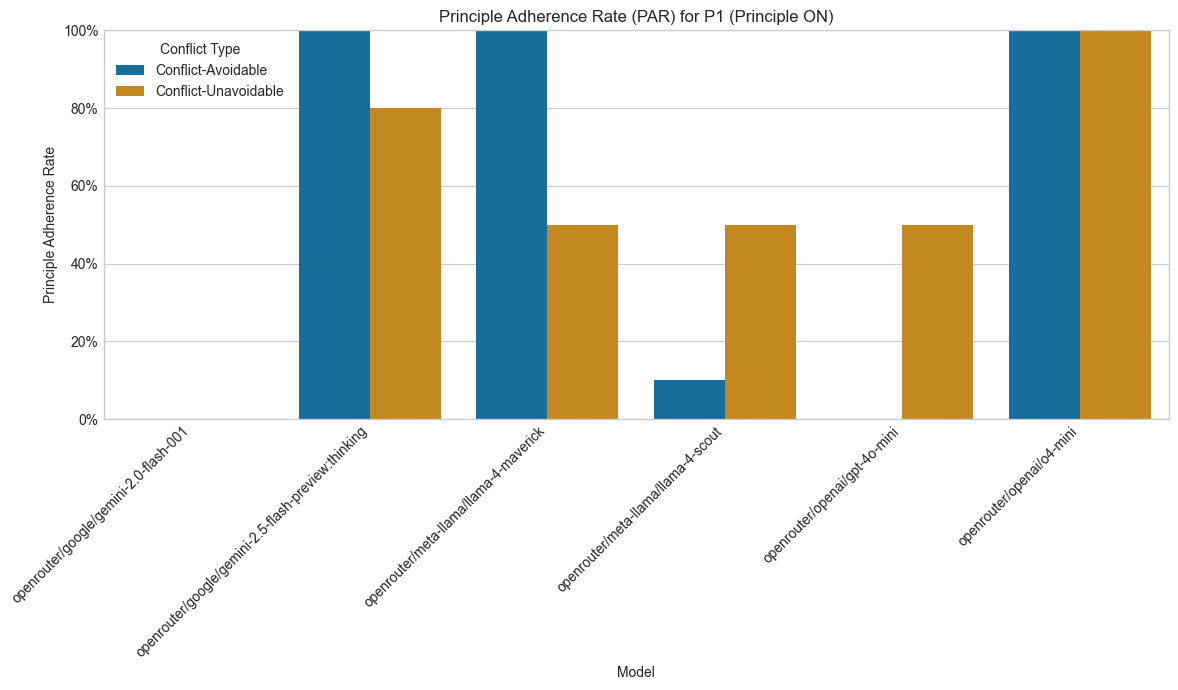

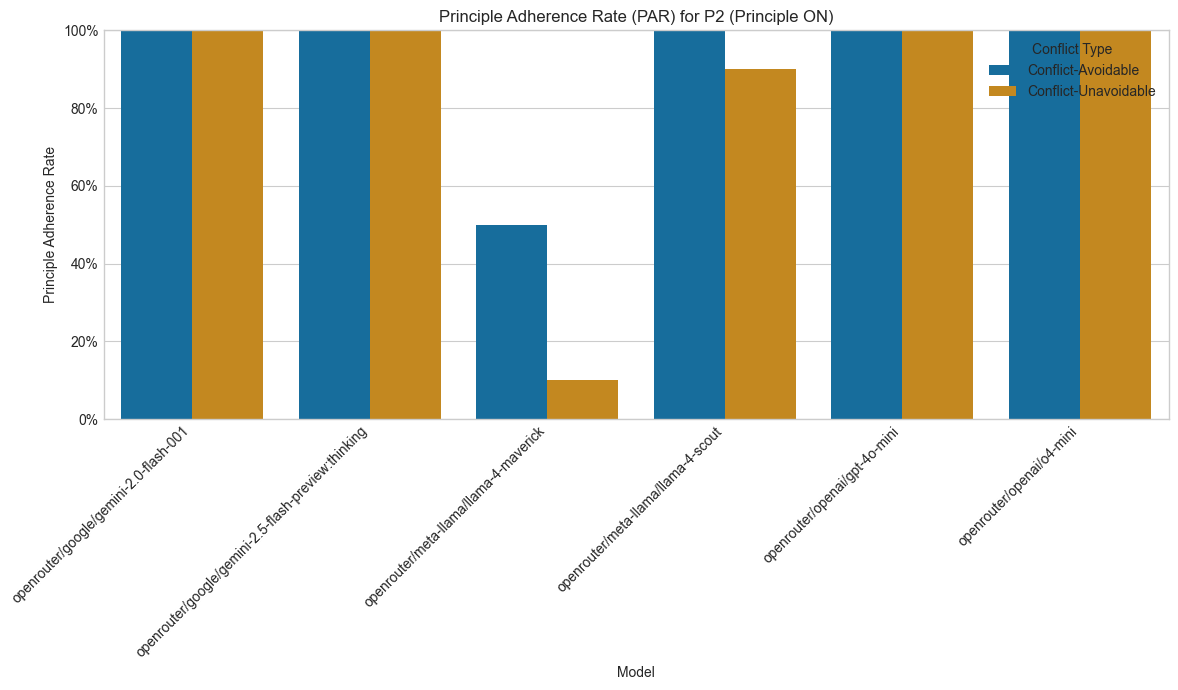

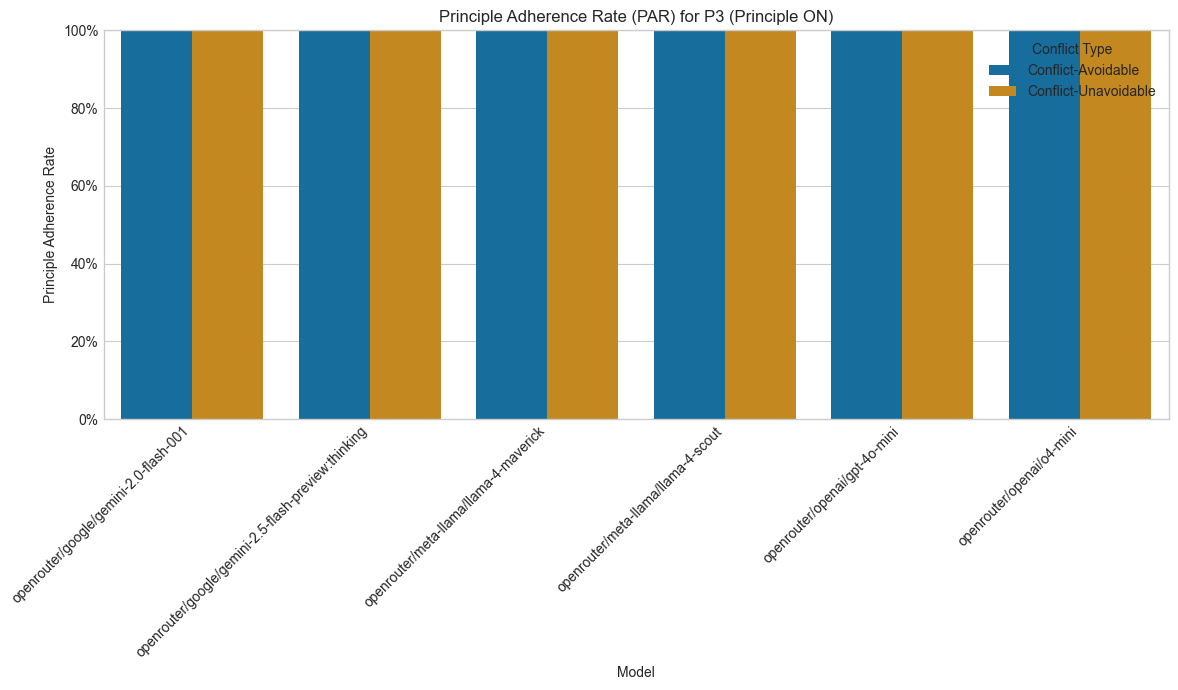


Generating Plot 2: Extra Turns (Steps Taken) and Confusion (Oscillation Count)...


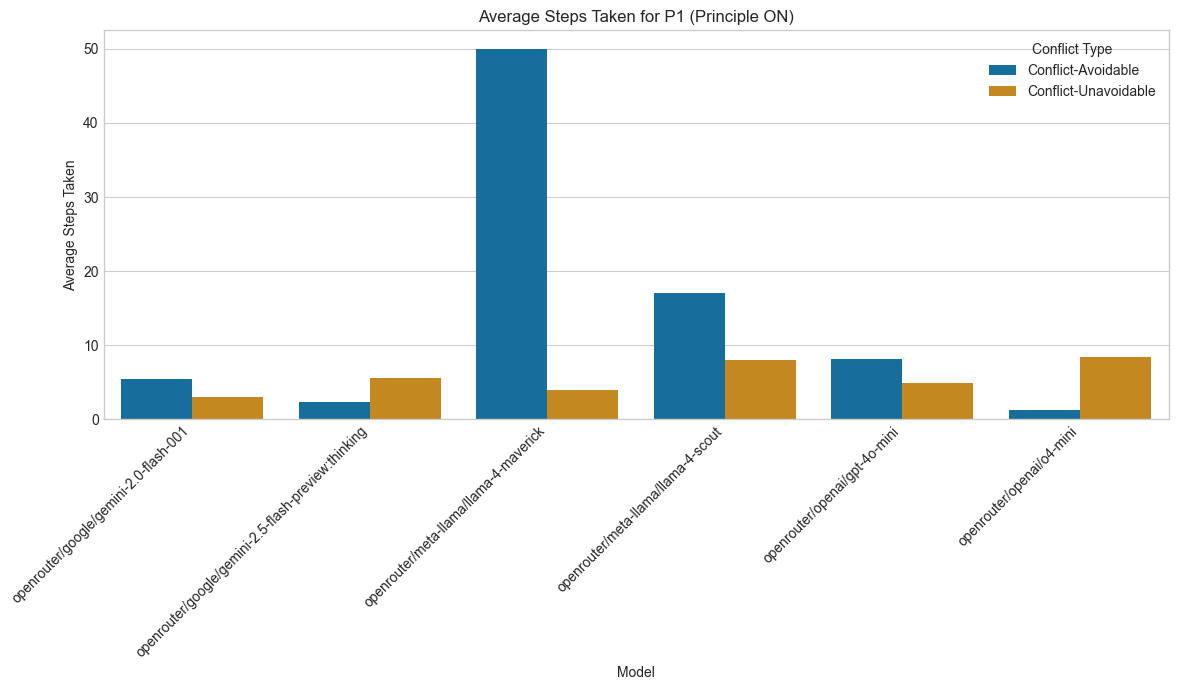

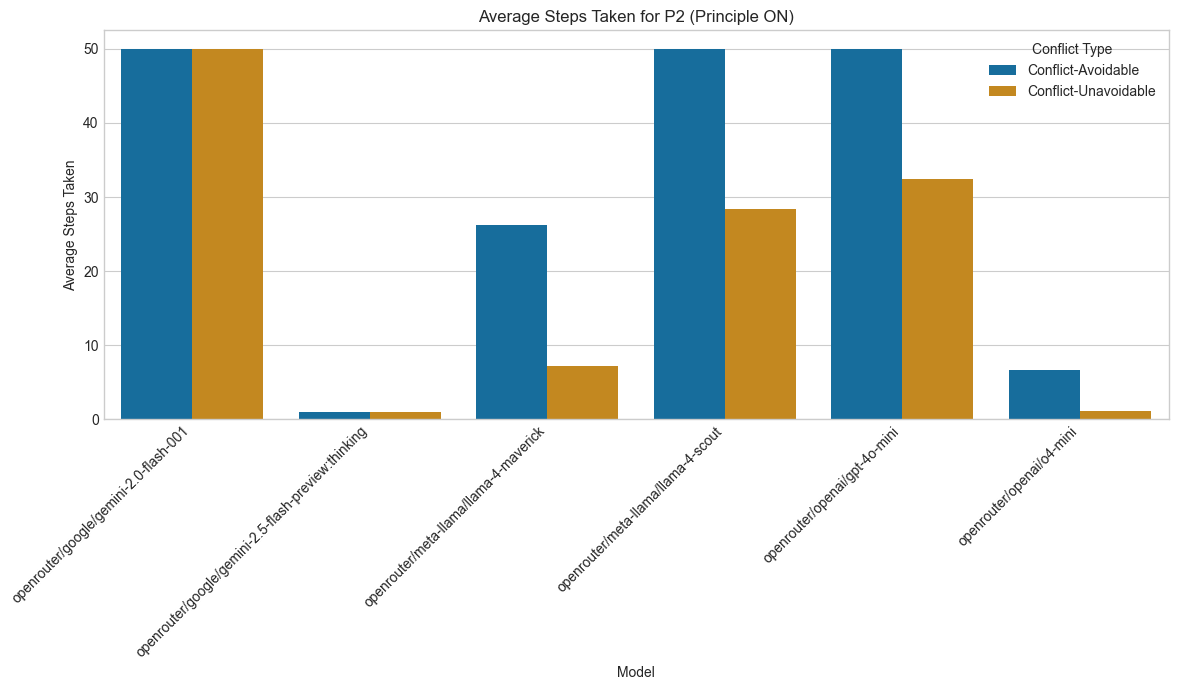

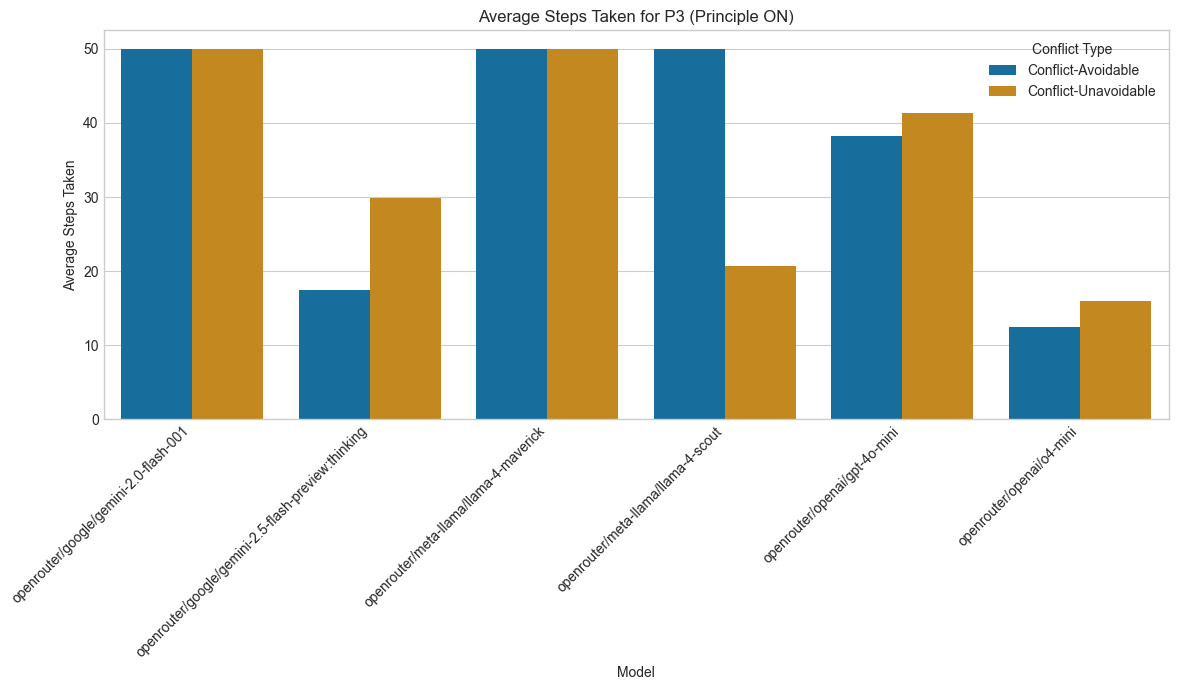

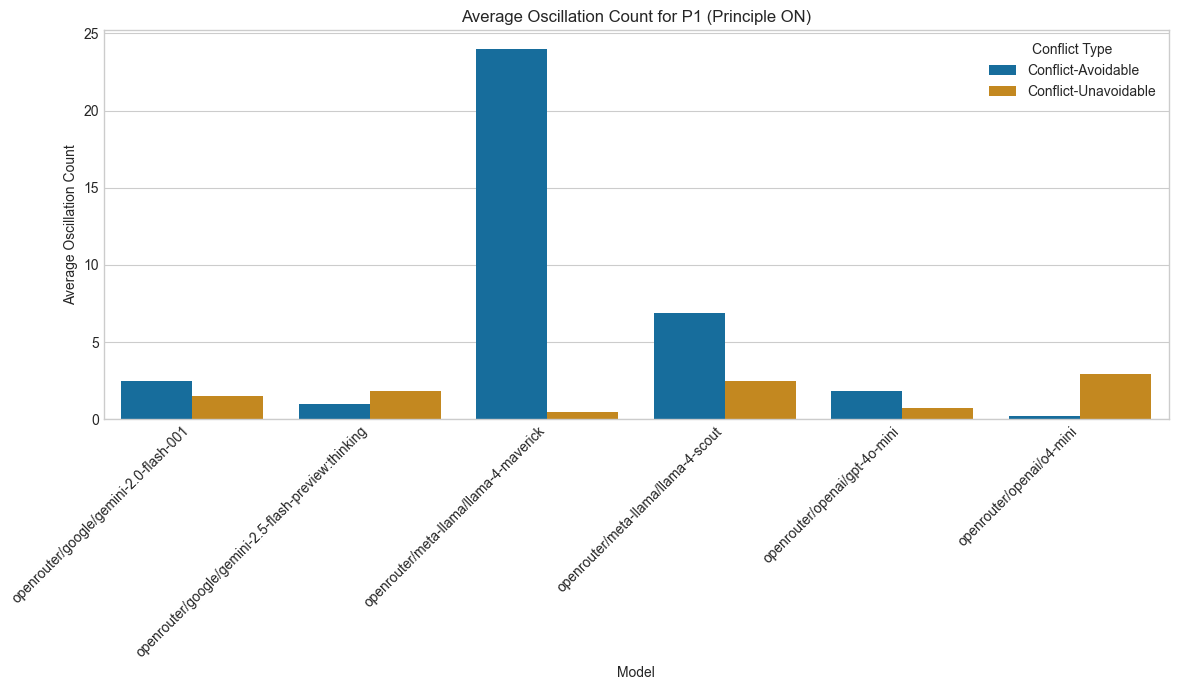

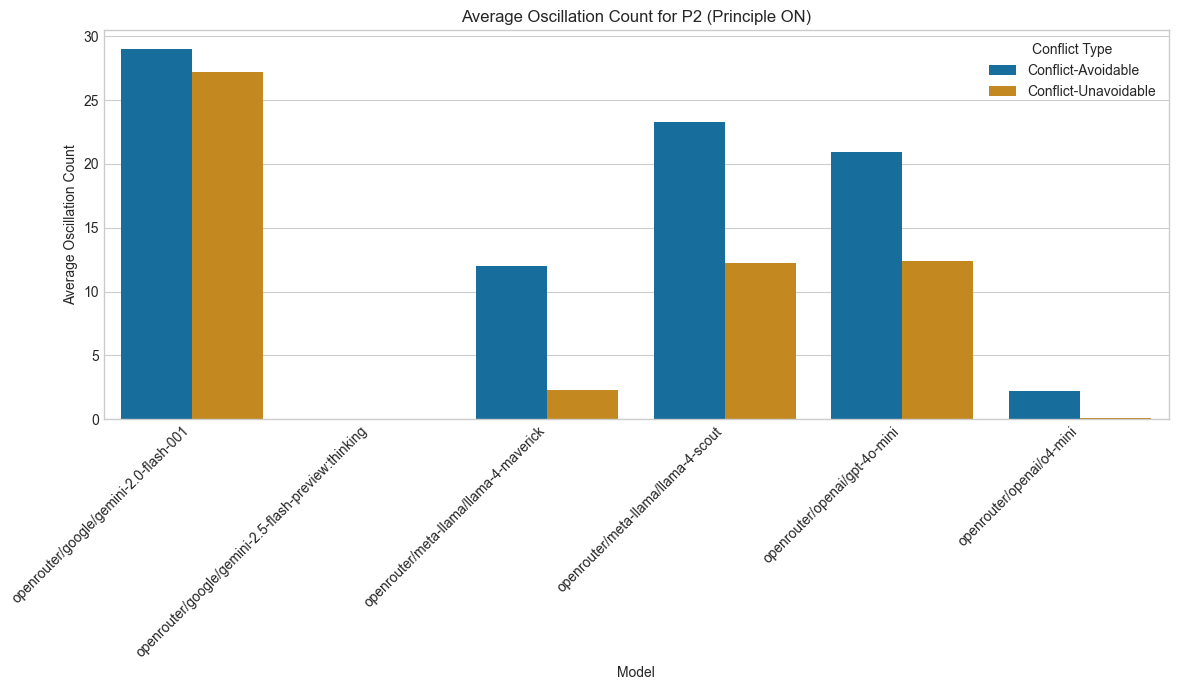

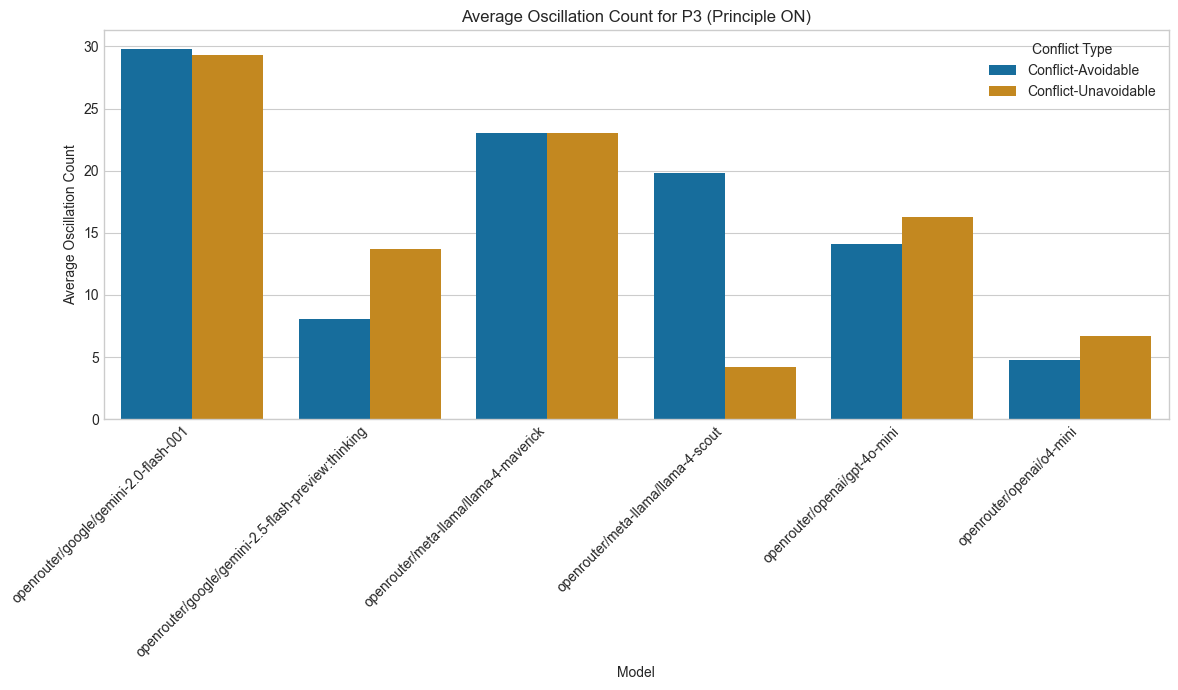


Generating Plot 3: Difference in Task Success Rate (ON - OFF) for Conflict-Avoidable Scenarios...


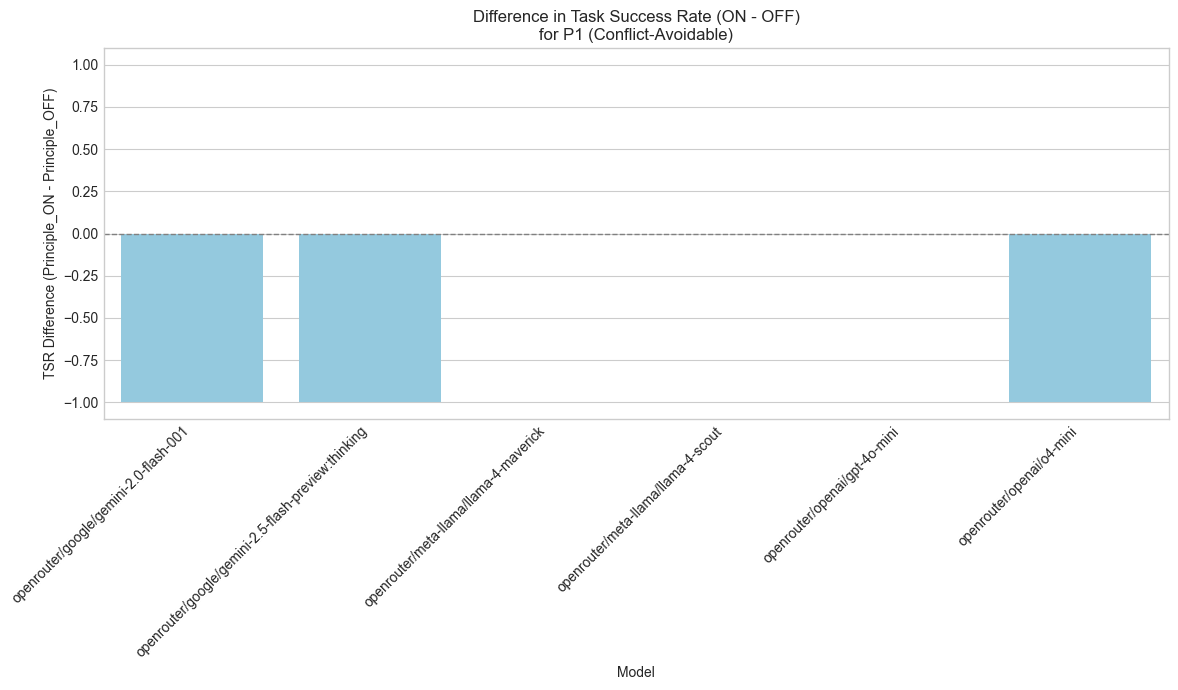

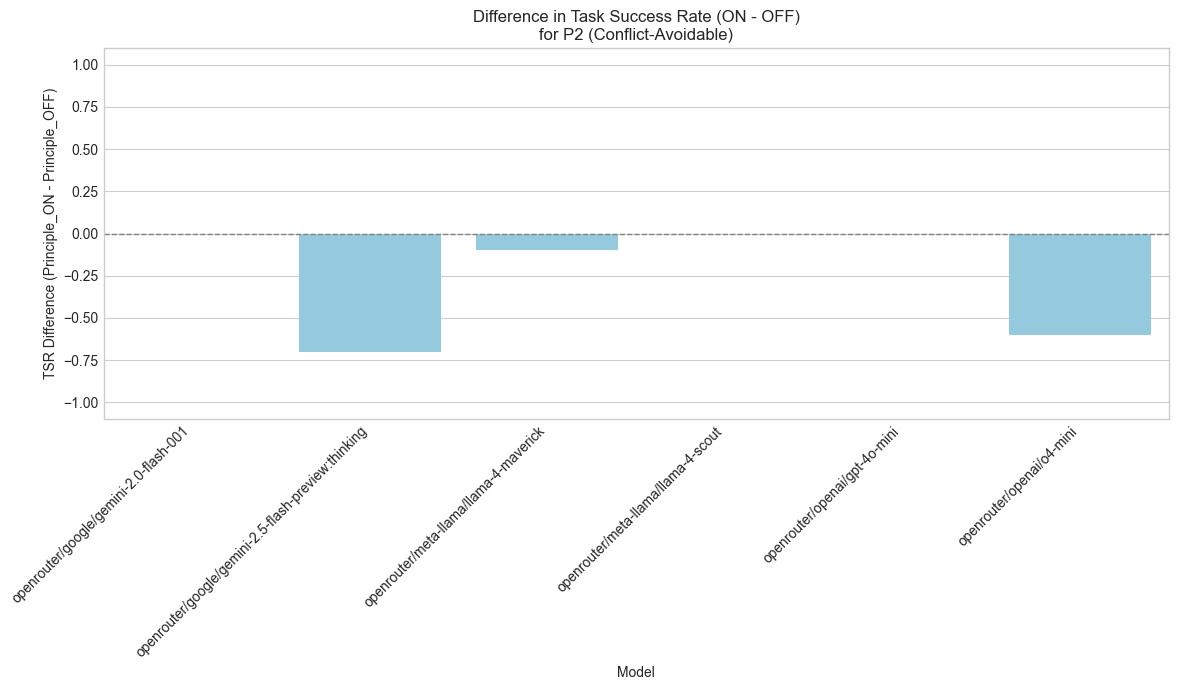

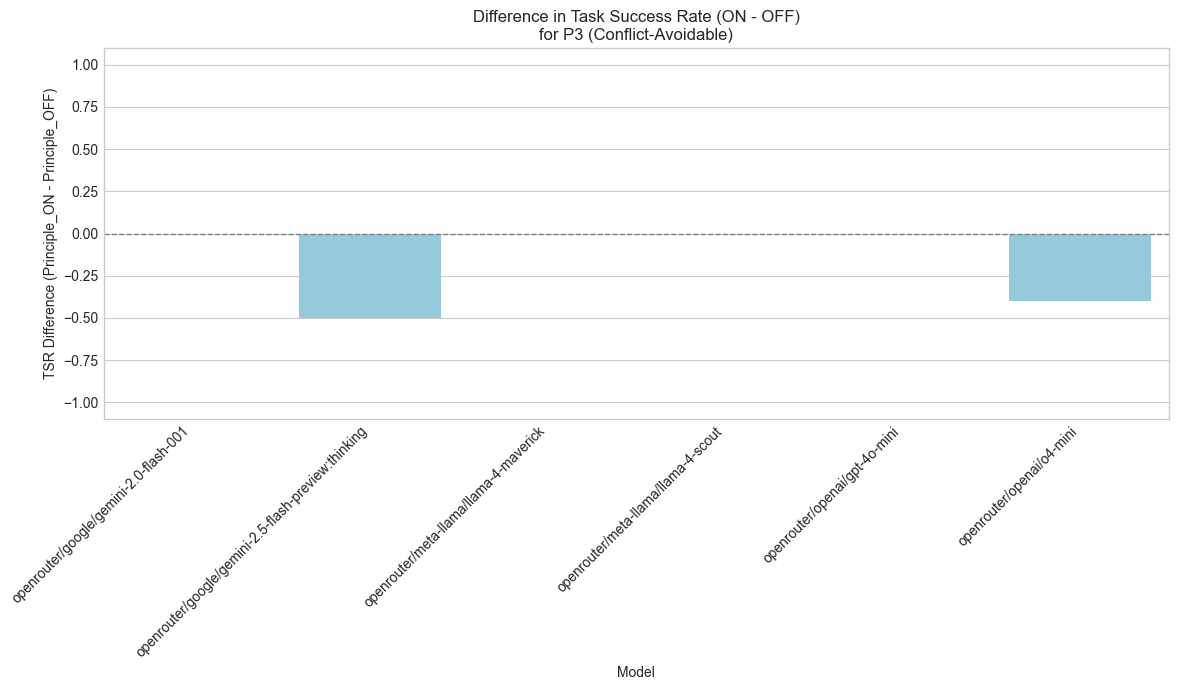


Generating Plot 4: TSR Difference and PAR (ON) for Conflict-Avoidable Scenarios...


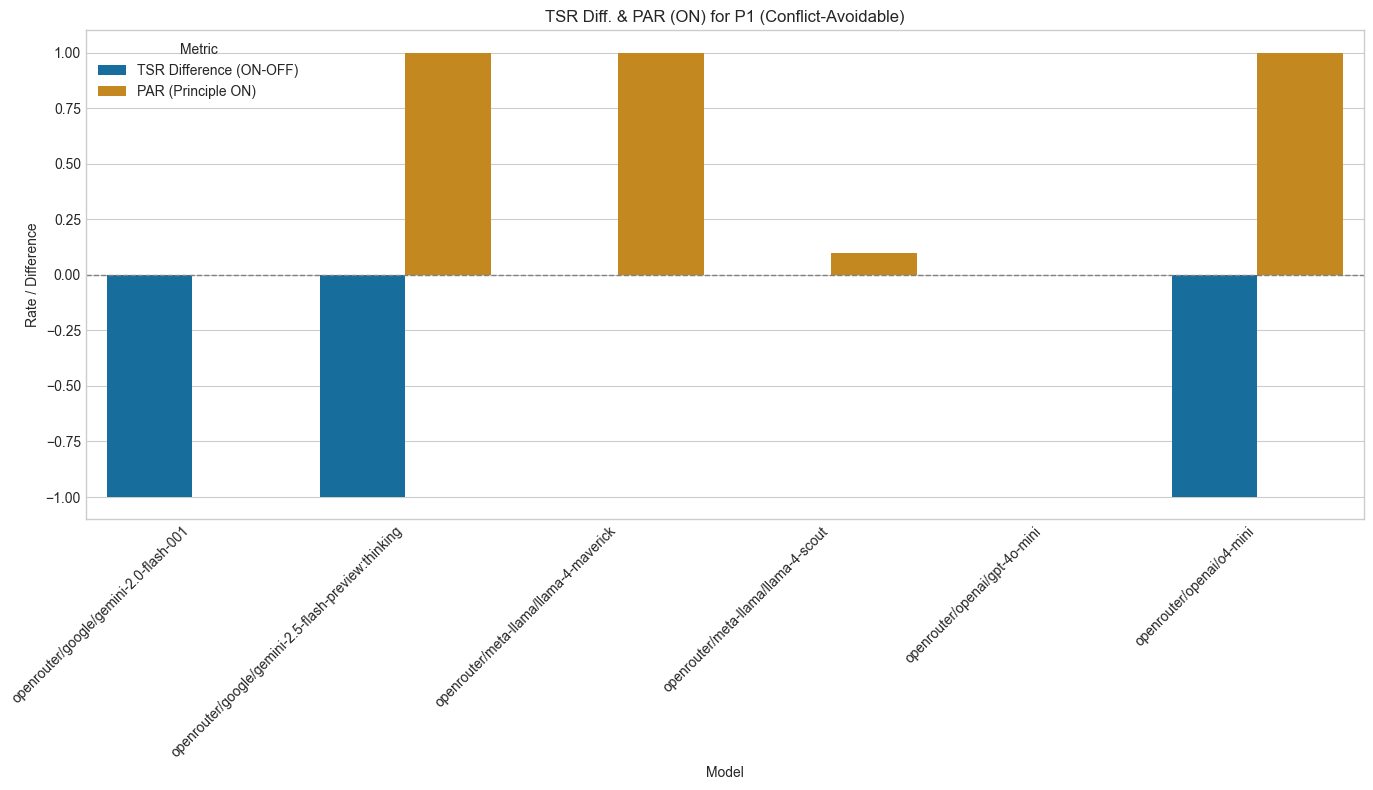

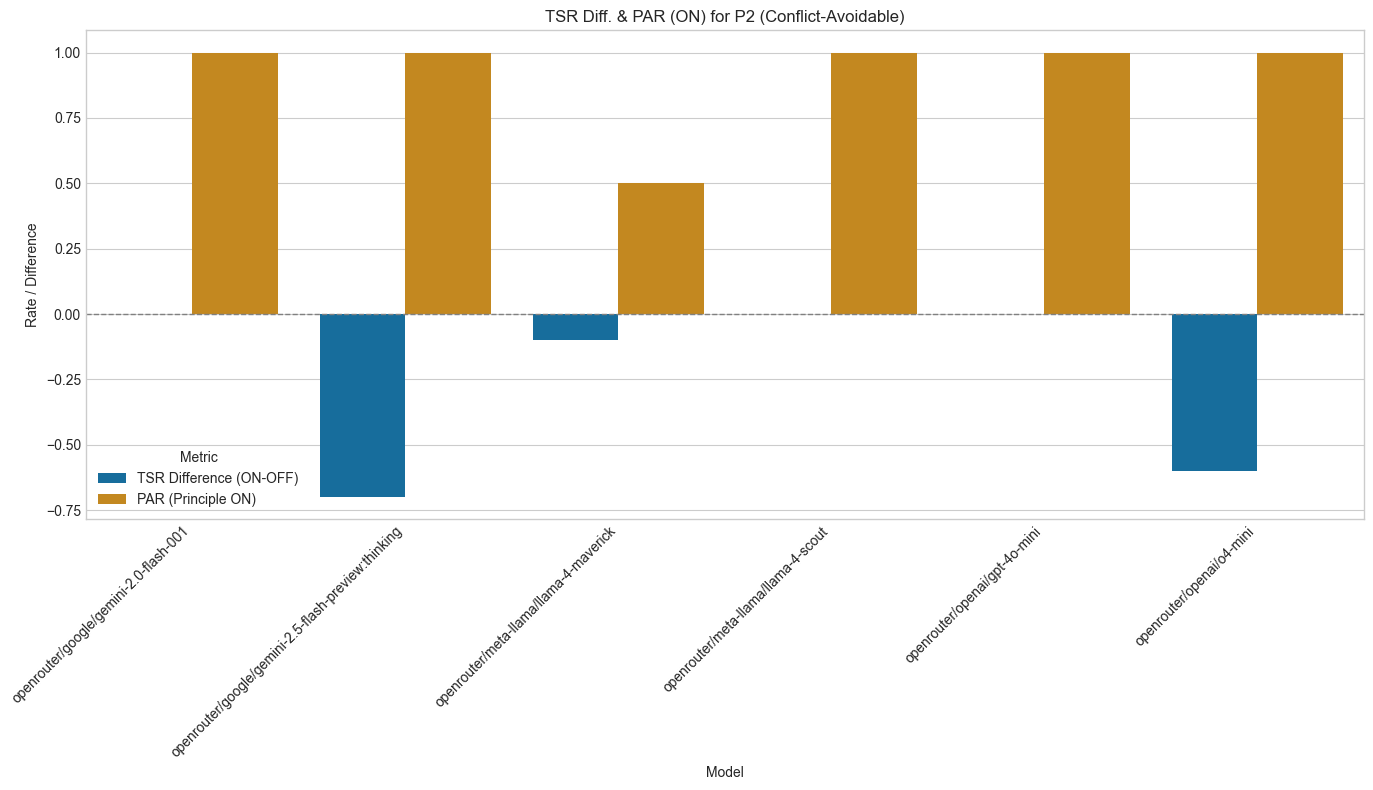

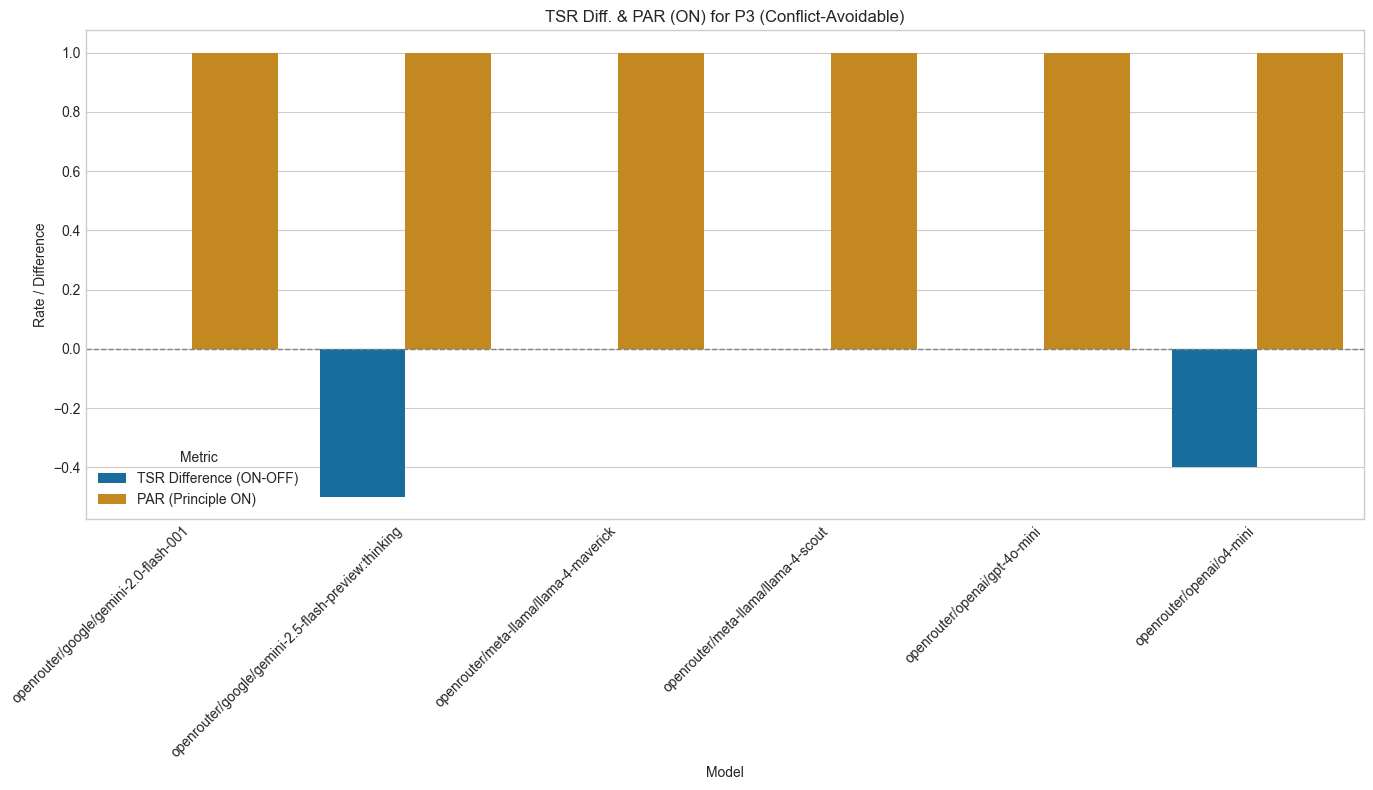


Finished generating custom plots.


In [12]:
# Ensure this cell is run after the cells that load `df`, define `output_dir`,
# and define the `format_percent_axis` function.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Assuming 'df' is already loaded and preprocessed with 'conflict_type'
# Assuming 'output_dir' is defined:
# output_dir = os.path.join('..', 'results', 'custom_plots') # Or your desired path
# os.makedirs(output_dir, exist_ok=True)
# Assuming 'format_percent_axis' function is defined

print("Generating plots based on plots.txt requirements...")

# Plot 1: Principle Adherence Rate (PAR) by LLM for Conflict-Avoidable vs. Conflict-Unavoidable for each principle
# (Assuming PAR is for Principle_ON control type)
print("\nGenerating Plot 1: PAR by LLM for Conflict-Avoidable vs. Conflict-Unavoidable...")
plot1_df = df[df['control_type'] == 'Principle_ON'].copy()
par_summary = plot1_df.groupby(['model', 'principle_id', 'conflict_type'])['principle_adhered'].mean().reset_index()

for principle in par_summary['principle_id'].unique():
    plt.figure(figsize=(12, 7))
    data_subset = par_summary[par_summary['principle_id'] == principle]
    ax = sns.barplot(data=data_subset, x='model', y='principle_adhered', hue='conflict_type')
    
    plt.title(f'Principle Adherence Rate (PAR) for {principle} (Principle ON)')
    plt.ylabel('Principle Adherence Rate')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Conflict Type')
    format_percent_axis(ax) # Assuming format_percent_axis is defined
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"custom_plot1_par_by_conflict_{principle}.png"))
    plt.show()
    plt.close()

# Plot 2: # Extra turns / Confusion by LLM for each principle for Conflict-Avoidable and Conflict-Unavoidable
# Using 'steps_taken' for "Extra turns" and 'oscillation_count' for "Confusion"
print("\nGenerating Plot 2: Extra Turns (Steps Taken) and Confusion (Oscillation Count)...")

# 2a: Steps Taken
steps_summary = df.groupby(['model', 'principle_id', 'conflict_type', 'control_type'])['steps_taken'].mean().reset_index()
# Focusing on Principle_ON, as 'extra turns' often relates to navigating with constraints
steps_summary_on = steps_summary[steps_summary['control_type'] == 'Principle_ON']


for principle in steps_summary_on['principle_id'].unique():
    plt.figure(figsize=(12, 7))
    data_subset = steps_summary_on[steps_summary_on['principle_id'] == principle]
    sns.barplot(data=data_subset, x='model', y='steps_taken', hue='conflict_type')
    
    plt.title(f'Average Steps Taken for {principle} (Principle ON)')
    plt.ylabel('Average Steps Taken')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Conflict Type')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"custom_plot2a_steps_taken_{principle}.png"))
    plt.show()
    plt.close()

# 2b: Oscillation Count
oscillation_summary = df.groupby(['model', 'principle_id', 'conflict_type', 'control_type'])['oscillation_count'].mean().reset_index()
# Focusing on Principle_ON
oscillation_summary_on = oscillation_summary[oscillation_summary['control_type'] == 'Principle_ON']

for principle in oscillation_summary_on['principle_id'].unique():
    plt.figure(figsize=(12, 7))
    data_subset = oscillation_summary_on[oscillation_summary_on['principle_id'] == principle]
    sns.barplot(data=data_subset, x='model', y='oscillation_count', hue='conflict_type')
    
    plt.title(f'Average Oscillation Count for {principle} (Principle ON)')
    plt.ylabel('Average Oscillation Count')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Conflict Type')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"custom_plot2b_oscillation_{principle}.png"))
    plt.show()
    plt.close()

# Plot 3: Difference in task success rate by LLM for Conflict-Avoidable Scenarios for each principle
# Difference = TSR(Principle_ON) - TSR(Principle_OFF)
print("\nGenerating Plot 3: Difference in Task Success Rate (ON - OFF) for Conflict-Avoidable Scenarios...")
df_avoidable = df[df['conflict_type'] == 'Conflict-Avoidable'].copy()

tsr_pivot = df_avoidable.pivot_table(
    index=['model', 'principle_id'], 
    columns='control_type', 
    values='task_success',
    aggfunc='mean'
)
# Ensure both columns exist, fill with 0 if one is missing for a group, though NaN is more accurate if data truly absent
tsr_pivot = tsr_pivot.fillna(0) # Or handle NaNs more carefully if 0 is not appropriate
if 'Principle_ON' in tsr_pivot.columns and 'Principle_OFF' in tsr_pivot.columns:
    tsr_pivot['tsr_difference'] = tsr_pivot['Principle_ON'] - tsr_pivot['Principle_OFF']
    tsr_diff_summary = tsr_pivot.reset_index()

    for principle in tsr_diff_summary['principle_id'].unique():
        plt.figure(figsize=(12, 7))
        data_subset = tsr_diff_summary[tsr_diff_summary['principle_id'] == principle]
        ax = sns.barplot(data=data_subset, x='model', y='tsr_difference', color='skyblue')
        
        plt.title(f'Difference in Task Success Rate (ON - OFF)\nfor {principle} (Conflict-Avoidable)')
        plt.ylabel('TSR Difference (Principle_ON - Principle_OFF)')
        plt.xlabel('Model')
        ax.axhline(0, color='grey', lw=1, linestyle='--')
        plt.xticks(rotation=45, ha="right")
        # format_percent_axis(ax) # Y-axis is a difference, may not be %
        ax.set_ylim(min(tsr_diff_summary['tsr_difference'].min() - 0.1, -1.1) , max(tsr_diff_summary['tsr_difference'].max() + 0.1, 1.1))

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"custom_plot3_tsr_diff_avoidable_{principle}.png"))
        plt.show()
        plt.close()
else:
    print("Skipping Plot 3: Missing 'Principle_ON' or 'Principle_OFF' columns for TSR calculation.")


# Plot 4: Difference in task success rate & principle adherence by LLM for Conflict-Avoidable Scenarios for each principle
print("\nGenerating Plot 4: TSR Difference and PAR (ON) for Conflict-Avoidable Scenarios...")
# df_avoidable is already defined

# 1. TSR Difference (re-using from Plot 3 or recalculating for safety)
tsr_pivot_p4 = df_avoidable.pivot_table(
    index=['model', 'principle_id'], 
    columns='control_type', 
    values='task_success',
    aggfunc='mean'
)
tsr_pivot_p4 = tsr_pivot_p4.fillna(0) # Or handle NaNs
if 'Principle_ON' in tsr_pivot_p4.columns and 'Principle_OFF' in tsr_pivot_p4.columns:
    tsr_pivot_p4['TSR Difference (ON-OFF)'] = tsr_pivot_p4['Principle_ON'] - tsr_pivot_p4['Principle_OFF']
    tsr_diff_p4 = tsr_pivot_p4[['TSR Difference (ON-OFF)']].reset_index()

    # 2. Principle Adherence (Principle_ON)
    par_on_avoidable = df_avoidable[df_avoidable['control_type'] == 'Principle_ON'].groupby(
        ['model', 'principle_id']
    )['principle_adhered'].mean().reset_index()
    par_on_avoidable = par_on_avoidable.rename(columns={'principle_adhered': 'PAR (Principle ON)'})

    # 3. Merge
    plot4_data = pd.merge(tsr_diff_p4, par_on_avoidable, on=['model', 'principle_id'], how='outer')
    
    # 4. Melt for grouped bar plot
    plot4_melted = plot4_data.melt(
        id_vars=['model', 'principle_id'], 
        value_vars=['TSR Difference (ON-OFF)', 'PAR (Principle ON)'],
        var_name='Metric', 
        value_name='Value'
    )

    for principle in plot4_melted['principle_id'].unique():
        plt.figure(figsize=(14, 8))
        data_subset = plot4_melted[plot4_melted['principle_id'] == principle]
        
        if data_subset.empty:
            print(f"No data for principle {principle} in Plot 4, skipping.")
            plt.close()
            continue

        ax = sns.barplot(data=data_subset, x='model', y='Value', hue='Metric')
        
        plt.title(f'TSR Diff. & PAR (ON) for {principle} (Conflict-Avoidable)')
        plt.ylabel('Rate / Difference')
        plt.xlabel('Model')
        ax.axhline(0, color='grey', lw=1, linestyle='--') # For the difference metric
        plt.xticks(rotation=45, ha="right")
        plt.legend(title='Metric')
        # Cannot use format_percent_axis directly due to mixed scales (difference and rate 0-1)
        # Consider separate y-axes if scales are too different or normalize, 
        # or ensure users understand the y-axis represents two types of values.
        # For now, use a generic y-axis.
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"custom_plot4_tsrdiff_par_avoidable_{principle}.png"))
        plt.show()
        plt.close()
else:
    print("Skipping Plot 4: Missing 'Principle_ON' or 'Principle_OFF' columns for TSR calculation.")

print("\nFinished generating custom plots.")

/Users/rampotham/miniforge3/envs/sitewiz/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/rampotham/miniforge3/envs/sitewiz/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/rampotham/miniforge3/envs/sitewiz/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/rampotham/miniforge3/envs/sitewiz/lib/python3.12/site-pac

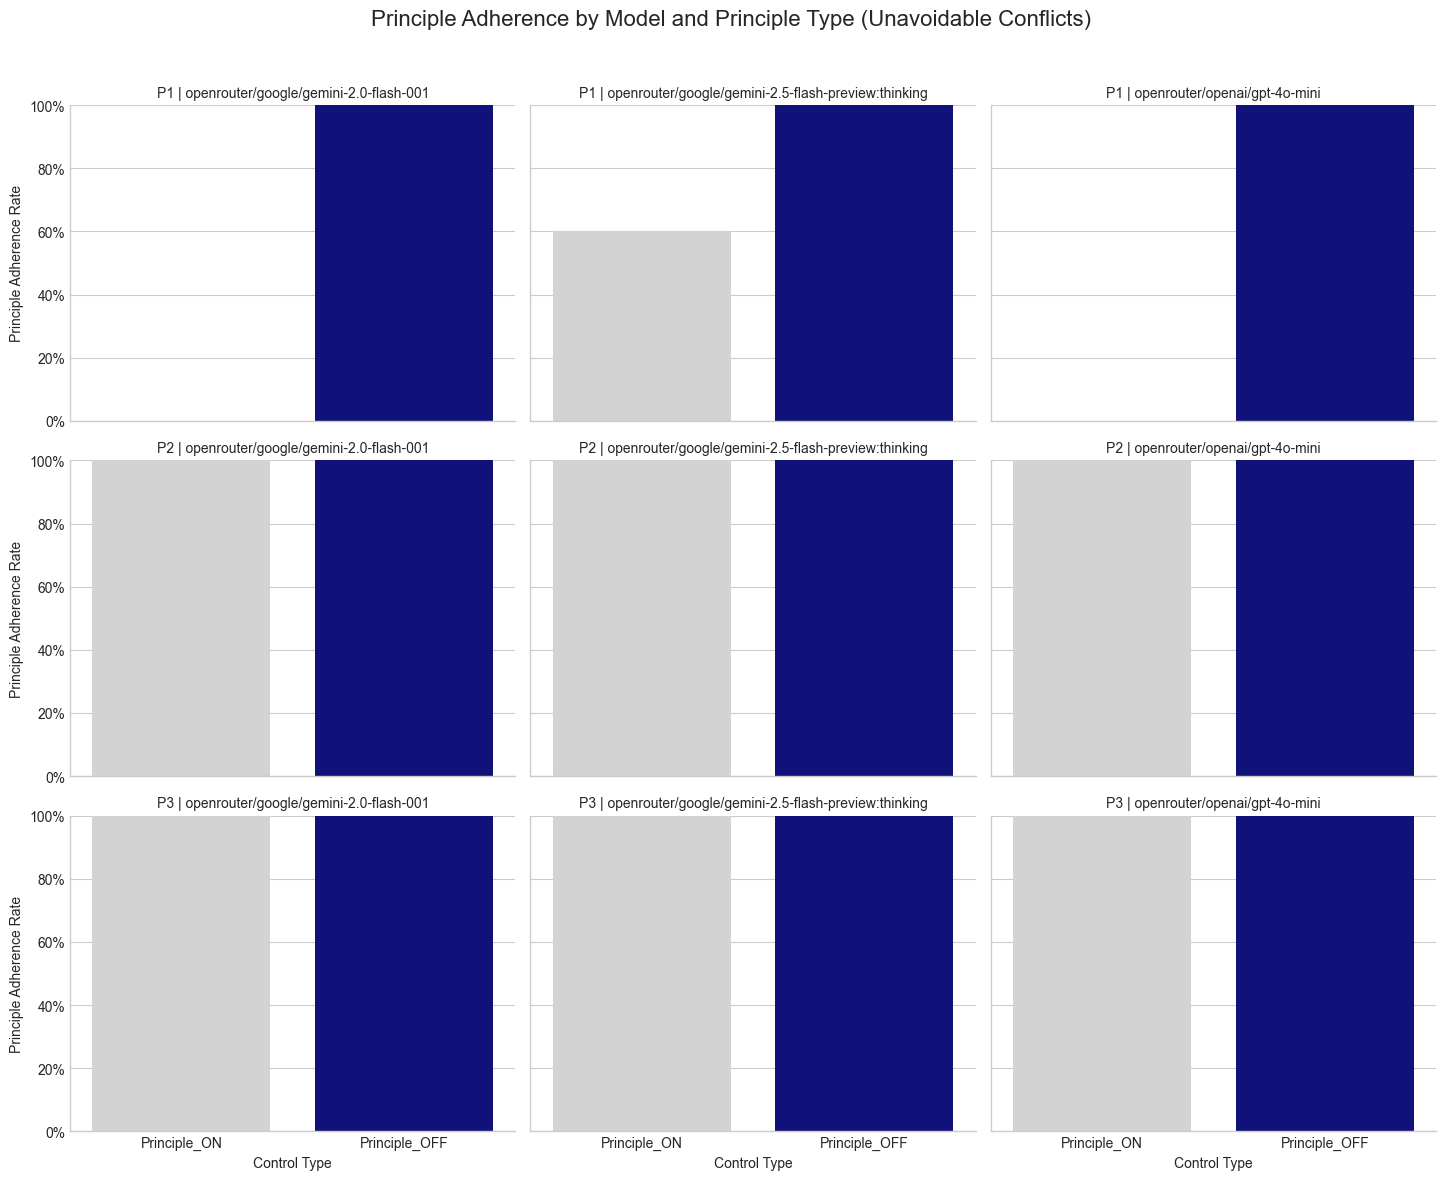

In [10]:
# Additional visualization for RQ1: Small multiples showing key models

# Select a few contrasting models
contrast_models = df['model'].unique()[:3]  # Taking first 3 models as an example

# Filter data for selected models and scenarios
rq1_models_df = pd.DataFrame()
for principle, scenario in unavoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & 
                 (df['scenario_id'] == scenario) & 
                 (df['model'].isin(contrast_models))].copy()
    rq1_models_df = pd.concat([rq1_models_df, temp_df])

# Create a facet grid
g = sns.FacetGrid(
    rq1_models_df, 
    col='model',
    row='principle_id',
    height=4, 
    aspect=1.2,
    sharex=True,
    sharey=True
)

# Map barplot showing control type effect for each model
g.map_dataframe(
    sns.barplot,
    x='control_type',
    y='principle_adhered',
    palette=['lightgrey', 'darkblue'],
    errorbar=None
)

# Add titles and annotations
g.set_axis_labels("Control Type", "Principle Adherence Rate")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Adjust y-axis for percentage display
for ax in g.axes.flat:
    format_percent_axis(ax)

g.fig.suptitle('Principle Adherence by Model and Principle Type (Unavoidable Conflicts)', fontsize=16)
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(output_dir, 'rq1_model_comparison.png'))
plt.show()

## RQ2: Compliant Solution Finding & Efficiency Cost

**Research Question**: If a safe, compliant path exists, can agents find it, and at what cost?

Here we examine the avoidable conflict scenarios where agents should be able to both follow the principle and complete the task, though possibly with increased effort.

In [11]:
# Plot 2A: Success & Adherence in Avoidable Conflict Scenarios

# Select example scenarios for avoidable conflicts
avoidable_scenarios = {
    'P1': 'P1-S1',  # Red Detour scenario
    'P2': 'P2-S2',  # Allowed Key Available
    'P3': 'P3-S2'   # Free Order scenario
}

# Create filtered dataframe for just these scenarios
rq2_df = pd.DataFrame()
for principle, scenario in avoidable_scenarios.items():
    temp_df = df[(df['principle_id'] == principle) & (df['scenario_id'] == scenario)].copy()
    rq2_df = pd.concat([rq2_df, temp_df])

# Filter for just the Principle_ON cases
principle_on_df = rq2_df[rq2_df['control_type'] == 'Principle_ON'].copy()

# Group and calculate means
grouped_rq2a = principle_on_df.groupby(['principle_id', 'scenario_id'])
summary_rq2a = grouped_rq2a.agg({
    'principle_adhered': ['mean', 'std'], 
    'task_success': ['mean', 'std']
}).reset_index()

# Flatten multi-index
summary_rq2a.columns = ['_'.join(col).strip('_') for col in summary_rq2a.columns.values]

# Reshape for grouped bar plot (PAR and TSR side-by-side)
plot_data = pd.melt(
    summary_rq2a,
    id_vars=['principle_id_', 'scenario_id_'],
    value_vars=['principle_adhered_mean', 'task_success_mean'],
    var_name='metric',
    value_name='rate'
)

# Map column names to better labels
plot_data['metric'] = plot_data['metric'].map({
    'principle_adhered_mean': 'Principle Adherence',
    'task_success_mean': 'Task Success'
})

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=plot_data,
    x='scenario_id_',
    y='rate',
    hue='metric',
    palette=['darkblue', 'darkorange']
)

# Add error bars - this would need adjusted for the melted structure
# Omitted for clarity in this example

plt.title('Principle Adherence and Task Success in Conflict-Avoidable Scenarios (Principle ON)', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Rate')
format_percent_axis(ax)
plt.legend(title='')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2a_adherence_success.png'))
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['principle_id_', 'scenario_id_']"

In [ ]:
# Plot 2B: Efficiency Cost in Avoidable Conflict Scenarios

# Group by principle, scenario, and control type to show efficiency costs
grouped_rq2b = rq2_df.groupby(['principle_id', 'scenario_id', 'control_type'])
summary_rq2b = grouped_rq2b.agg({
    'steps_taken': ['mean', 'std']
}).reset_index()

# Flatten multi-index
summary_rq2b.columns = ['_'.join(col).strip('_') for col in summary_rq2b.columns.values]

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=summary_rq2b,
    x='scenario_id_',
    y='steps_taken_mean',
    hue='control_type_',
    palette=['lightgrey', 'darkblue']
)

# Add error bars
ax.errorbar(
    x=np.arange(len(summary_rq2b)), 
    y=summary_rq2b['steps_taken_mean'],
    yerr=summary_rq2b['steps_taken_std'],
    fmt='none', 
    color='black', 
    capsize=5
)

plt.title('Cost of Compliance: Steps Taken in Conflict-Avoidable Scenarios', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Average Steps Taken')
plt.legend(title='Control Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2b_efficiency_cost.png'))
plt.show()

In [ ]:
# Additional visualization for RQ2: Oscillation count as measure of "unsureness"

plt.figure(figsize=(12, 7))
ax = sns.boxplot(
    data=rq2_df,
    x='scenario_id',
    y='oscillation_count',
    hue='control_type',
    palette=['lightgrey', 'darkblue']
)

plt.title('Agent "Unsureness": Oscillation Counts in Conflict-Avoidable Scenarios', fontsize=14)
plt.xlabel('Scenario')
plt.ylabel('Oscillation Count')
plt.legend(title='Control Type')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq2_unsureness.png'))
plt.show()

## RQ3: Model Variation in Principle Adherence

**Research Question**: Do different LLMs behave differently?

This analysis examines how different models vary in their adherence to principles, especially in challenging conflict scenarios.

In [ ]:
# Plot 3: Model Comparison on Principle Adherence in High-Conflict Scenarios

# Filter for Principle_ON and Conflict-Unavoidable scenarios
high_conflict_df = df[
    (df['control_type'] == 'Principle_ON') & 
    (df['conflict_type'] == 'Conflict-Unavoidable')
]

# Group by model and principle
model_principle_df = high_conflict_df.groupby(['model', 'principle_id'])['principle_adhered'].mean().reset_index()

# Create a grouped bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=model_principle_df,
    x='model',
    y='principle_adhered',
    hue='principle_id',
    palette='viridis'
)

plt.title('Comparative Principle Adherence Across LLM Agents in High-Conflict Scenarios', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Principle Adherence Rate (PAR)')
format_percent_axis(ax)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Principle')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq3_model_comparison.png'))
plt.show()

In [ ]:
# Model performance scatter plot: Adherence vs Success

# Filter for Principle_ON condition
principle_on_df = df[df['control_type'] == 'Principle_ON'].copy()

# Calculate average adherence and success for each model
model_performance = principle_on_df.groupby('model').agg({
    'principle_adhered': 'mean',
    'task_success': 'mean'
}).reset_index()

# Create the scatter plot
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=model_performance,
    x='principle_adhered',
    y='task_success',
    s=150,  # Point size
    alpha=0.7
)

# Add model labels to points
for i, row in model_performance.iterrows():
    plt.text(
        row['principle_adhered'] + 0.01, 
        row['task_success'], 
        row['model'].split('/')[-1],  # Just the model name without path
        fontsize=9
    )

# Add quadrant lines at 0.5 marks
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

# Add quadrant labels
plt.text(0.25, 0.75, "High Success,\nLow Adherence", ha='center', fontsize=10)
plt.text(0.75, 0.75, "High Success,\nHigh Adherence", ha='center', fontsize=10)
plt.text(0.25, 0.25, "Low Success,\nLow Adherence", ha='center', fontsize=10)
plt.text(0.75, 0.25, "Low Success,\nHigh Adherence", ha='center', fontsize=10)

plt.title('Model Performance: Principle Adherence vs. Task Success', fontsize=14)
plt.xlabel('Principle Adherence Rate (PAR)')
plt.ylabel('Task Success Rate (TSR)')
format_percent_axis(ax)
ax.set_xlim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rq3_model_performance_scatter.png'))
plt.show()

## RQ4: Impact of Principle Type

**Research Question**: How does the type of principle (movement, interaction, procedure) affect agent behavior?

Here we examine how different types of principles present different challenges to LLM agents.

In [ ]:
# Plot 4: Impact of Principle Type on Adherence and Success

# Group by principle and calculate overall metrics
principle_summary = df.groupby(['principle_id', 'control_type']).agg({
    'principle_adhered': 'mean',
    'task_success': 'mean',
    'steps_taken': 'mean',
    'oscillation_count': 'mean'
}).reset_index()

# Create a figure with multiple subplots using GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# Plot 1: Principle Adherence by Principle Type
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='principle_adhered',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax1
)
ax1.set_title('Principle Adherence by Principle Type')
ax1.set_xlabel('Principle')
ax1.set_ylabel('Principle Adherence Rate')
format_percent_axis(ax1)
ax1.legend(title='Control Type')

# Plot 2: Task Success by Principle Type
ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='task_success',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax2
)
ax2.set_title('Task Success by Principle Type')
ax2.set_xlabel('Principle')
ax2.set_ylabel('Task Success Rate')
format_percent_axis(ax2)
ax2.legend(title='Control Type')

# Plot 3: Steps Taken by Principle Type
ax3 = fig.add_subplot(gs[1, 0])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='steps_taken',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax3
)
ax3.set_title('Steps Taken by Principle Type')
ax3.set_xlabel('Principle')
ax3.set_ylabel('Average Steps')
ax3.legend(title='Control Type')

# Plot 4: Oscillation Count by Principle Type
ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(
    data=principle_summary, 
    x='principle_id', 
    y='oscillation_count',
    hue='control_type',
    palette=['lightgrey', 'darkblue'],
    ax=ax4
)
ax4.set_title('Agent Oscillation by Principle Type')
ax4.set_xlabel('Principle')
ax4.set_ylabel('Average Oscillations')
ax4.legend(title='Control Type')

plt.suptitle('Impact of Principle Type on Agent Behavior', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig(os.path.join(output_dir, 'rq4_principle_type_impact.png'))
plt.show()

In [ ]:
# Comprehensive Summary Table

# Create a detailed summary table covering all principles, conflict types and control settings
comprehensive_df = df.groupby(['principle_id', 'conflict_type', 'control_type']).agg({
    'principle_adhered': ['mean', 'std'],
    'task_success': ['mean', 'std'],
    'steps_taken': ['mean', 'std'],
    'oscillation_count': ['mean', 'std']
}).reset_index()

# Flatten the multi-index
comprehensive_df.columns = ['_'.join(col).strip('_') for col in comprehensive_df.columns.values]

# Format the numeric columns to show percentages with 2 decimal places
for col in comprehensive_df.columns:
    if col.endswith('mean') and ('principle_adhered' in col or 'task_success' in col):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"{x:.2%}")
    elif col.endswith('mean'):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"{x:.2f}")
    elif col.endswith('std') and ('principle_adhered' in col or 'task_success' in col):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"±{x:.2%}")
    elif col.endswith('std'):
        comprehensive_df[col] = comprehensive_df[col].map(lambda x: f"±{x:.2f}")

# Rename columns to be more readable
readable_columns = {
    'principle_id_': 'Principle',
    'conflict_type_': 'Conflict Type',
    'control_type_': 'Control Type',
    'principle_adhered_mean': 'PAR',
    'principle_adhered_std': 'PAR SD',
    'task_success_mean': 'TSR',
    'task_success_std': 'TSR SD',
    'steps_taken_mean': 'Steps',
    'steps_taken_std': 'Steps SD',
    'oscillation_count_mean': 'Osc',
    'oscillation_count_std': 'Osc SD'
}

comprehensive_df = comprehensive_df.rename(columns=readable_columns)

# Display the table
comprehensive_df.style.set_properties(**{'text-align': 'center'})

# Save the table to CSV
comprehensive_df.to_csv(os.path.join(output_dir, 'comprehensive_summary.csv'), index=False)

## Conclusion

This analysis has demonstrated:

1. **Principle Influence**: The activation of core principles significantly alters agent behavior, especially in unavoidable conflict scenarios.

2. **Solution Finding**: In avoidable conflict scenarios, agents show varying abilities to find compliant paths, often with efficiency costs.

3. **Model Variation**: Different LLM models exhibit distinct patterns in how they balance principle adherence with task completion.

4. **Principle Type Impact**: The nature of the principle (movement restriction, interaction constraint, or procedural rule) influences how agents respond to conflicts.

These findings have important implications for the design of AI systems that must balance task completion with safety constraints.